In [2]:
import warnings
warnings.filterwarnings("ignore")

import sys 
sys.path.append("/glade/work/schreck/repos/HOLO/clean/holodec-ml")
from holodecml.data import *
from holodecml.losses import *
from holodecml.models import *
from holodecml.metrics import *
from holodecml.transforms import *
from holodecml.propagation import *

import os
import glob
import tqdm
import time
import yaml
import torch
import pickle
import joblib
import random
import sklearn
import logging
import datetime

import torch.fft
import torchvision
import torchvision.models as models

import numpy as np
import pandas as pd
import xarray as xr
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from collections import defaultdict
from scipy.signal import convolve2d
from torch.optim.lr_scheduler import *
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
from typing import List, Dict, Callable, Union, Any, TypeVar, Tuple


from colour import Color
import multiprocessing as mp
from functools import partial

In [3]:
%matplotlib inline

In [4]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

In [5]:
with open("/glade/work/schreck/repos/HOLO/clean/holodec-ml/config/unet_propagation.yml") as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [6]:
n_bins = conf["data"]["n_bins"]
tile_size = conf["data"]["tile_size"]
step_size = conf["data"]["step_size"]
marker_size = conf["data"]["marker_size"]
synthetic_path = conf["data"]["data_path"]

epochs = conf["trainer"]["epochs"]
train_batch_size = conf["trainer"]["train_batch_size"]
valid_batch_size = conf["trainer"]["valid_batch_size"]
batches_per_epoch = conf["trainer"]["batches_per_epoch"]
stopping_patience = conf["trainer"]["stopping_patience"]
model_loc = conf["trainer"]["output_path"]

model_name = conf["model"]["name"]
color_dim = conf["model"]["color_dim"]
inference_mode = conf["model"]["mode"]

learning_rate = conf["optimizer"]["learning_rate"]
weight_decay = conf["optimizer"]["weight_decay"]

In [7]:
try:
    os.mkdir(f"{model_loc}/propagated")
except FileExistsError:
    pass
try:
    os.mkdir(f"{model_loc}/roc")
except FileExistsError:
    pass
try:
    os.mkdir(f"{model_loc}/images")
except FileExistsError:
    pass

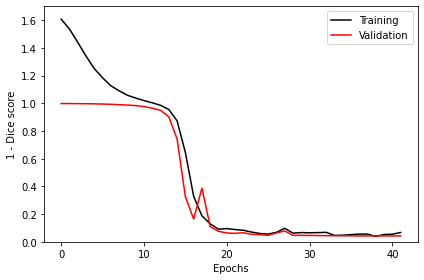

In [8]:
# Load a model
f = pd.read_csv(f"{model_loc}/training_log.csv")
plt.plot(f["epoch"], f["train_loss"], c = 'k')
plt.plot(f["epoch"], f["valid_loss"], c = 'r')
plt.ylim([0.0, 1.7])
plt.xlabel("Epochs")
plt.ylabel("1 - Dice score")
plt.legend(["Training", "Validation"], loc = "best")
plt.tight_layout()

In [9]:
model = ResNetUNet(
    n_class = 1, 
    color_dim = color_dim
).to(device)

checkpoint = torch.load(
    f"{model_loc}/best.pt",
    map_location=lambda storage, loc: storage
)
model.load_state_dict(checkpoint["model_state_dict"])

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"There are {total_params} total model parameters")

There are 18313833 total model parameters


In [10]:
prop = InferencePropagator(
    synthetic_path, 
    n_bins = n_bins,
    tile_size = tile_size,
    step_size = step_size,
    marker_size = marker_size,
    device = device,
    model = model,
    mode = inference_mode
)

In [11]:
h_idx = 10
test_image = prop.h_ds['image'].isel(hologram_number=h_idx)

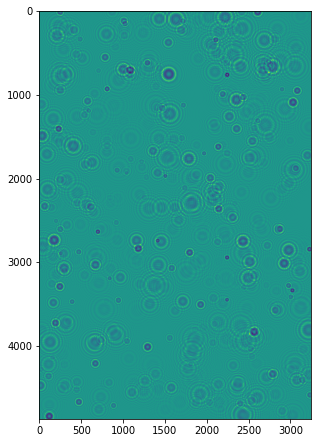

In [12]:
shape = test_image.values.shape
ratio = shape[0] / shape[1]

plt.figure(figsize = (5, 5 * ratio))
plt.imshow(test_image.values)

### Create a list of z-values to propagate to

In [13]:
z_list = prop.create_z_plane_lst(planes_per_call=1)

### Set up thresholds to use for computing ROC

In [13]:
obs_threshold = 1.0
thresholds = 1.0 - np.logspace(-5, 0, num=50, endpoint=True, base=10.0, dtype=None, axis=0)
thresholds = thresholds[::-1]

### Initialize the generator

In [14]:
inference_generator = prop.get_next_z_planes_labeled(
    h_idx, 
    z_list, 
    batch_size = valid_batch_size, 
    thresholds = thresholds,
    obs_threshold = obs_threshold
)

In [25]:
1e6 * (prop.h_ds.attrs['zMax'] - prop.h_ds.attrs['zMin']) / 1000

144.0

### Main loop to call the generator, predict with the model, and aggregate and save the results

Plane: 0 at z: 0.01436 plane_f1: 0.8839 holo_f1: 0.8839 plane_csi: 0.8236 holo_csi: 0.8236:   0%|          | 1/1000 [00:13<3:48:15, 13.71s/it]

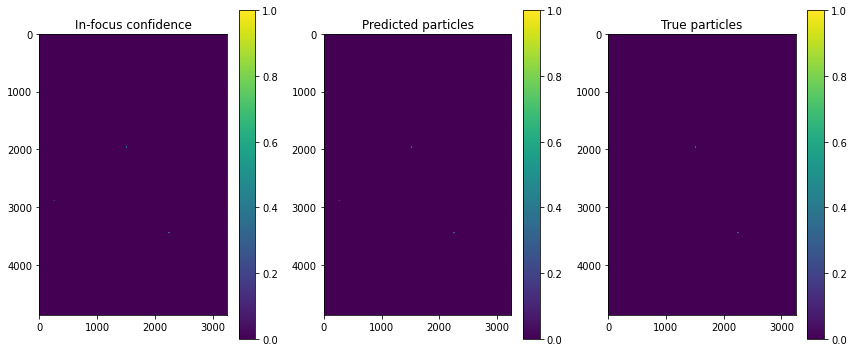

Plane: 1 at z: 0.014504 plane_f1: nan holo_f1: 0.6073 plane_csi: 0.0000 holo_csi: 0.4512:   0%|          | 3/1000 [00:29<2:47:55, 10.11s/it]  

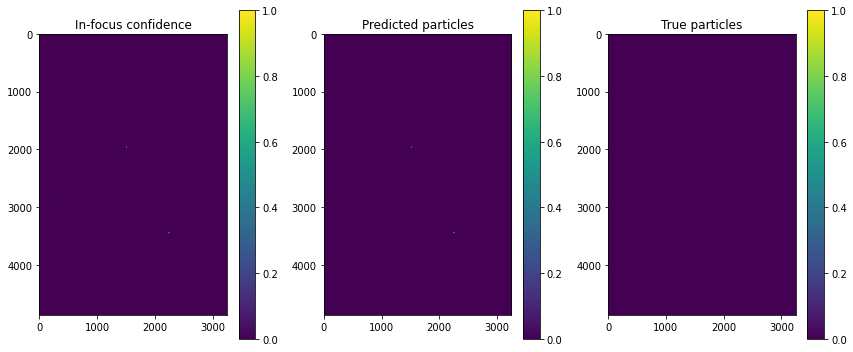

Plane: 2 at z: 0.014648 plane_f1: nan holo_f1: 0.6072 plane_csi: 0.0000 holo_csi: 0.4512:   0%|          | 4/1000 [00:45<3:24:31, 12.32s/it]

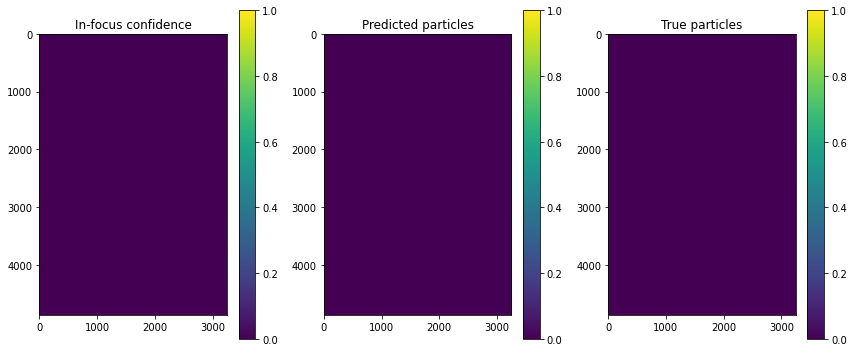

Plane: 3 at z: 0.014792 plane_f1: nan holo_f1: 0.6072 plane_csi: 0.0000 holo_csi: 0.4512:   1%|          | 6/1000 [01:01<2:51:42, 10.36s/it]

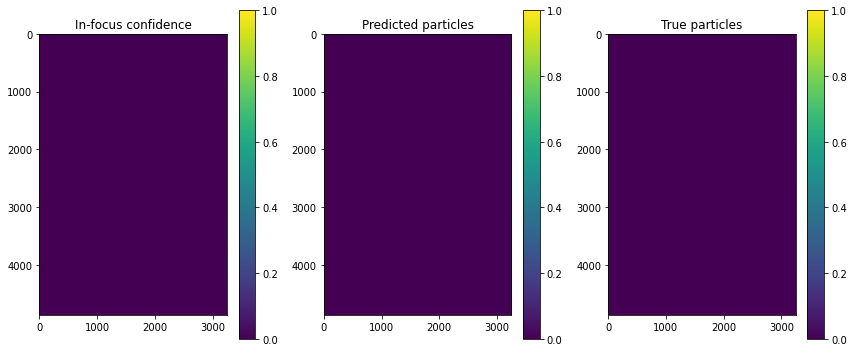

Plane: 4 at z: 0.014936 plane_f1: nan holo_f1: 0.6072 plane_csi: 0.0000 holo_csi: 0.4512:   1%|          | 7/1000 [01:17<3:20:36, 12.12s/it]

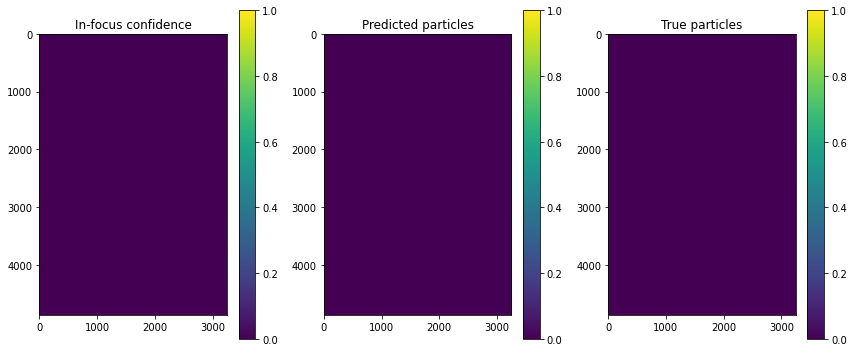

Plane: 5 at z: 0.01508 plane_f1: nan holo_f1: 0.6072 plane_csi: 0.0000 holo_csi: 0.4512:   1%|          | 8/1000 [01:32<3:39:15, 13.26s/it] 

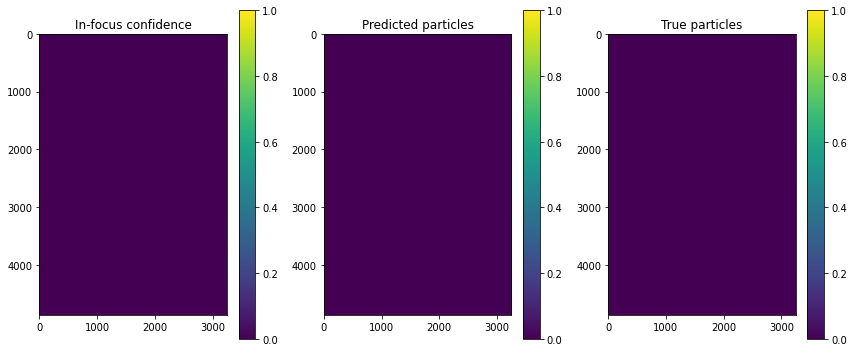

Plane: 6 at z: 0.015224 plane_f1: nan holo_f1: 0.6072 plane_csi: 0.0000 holo_csi: 0.4512:   1%|          | 10/1000 [01:48<3:00:36, 10.95s/it]

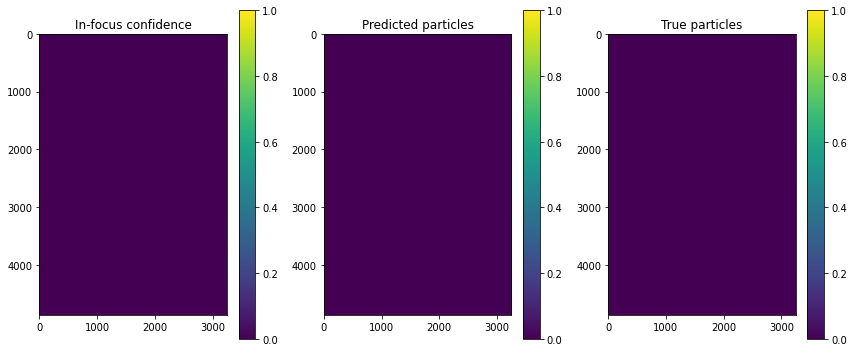

Plane: 7 at z: 0.015368 plane_f1: nan holo_f1: 0.6067 plane_csi: 0.0000 holo_csi: 0.4512:   1%|          | 11/1000 [02:04<3:25:06, 12.44s/it]

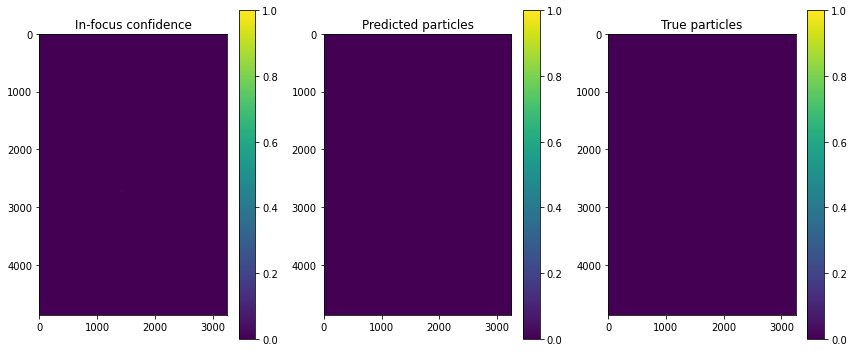

Plane: 8 at z: 0.015512 plane_f1: nan holo_f1: 0.5262 plane_csi: 0.0000 holo_csi: 0.3692:   1%|          | 12/1000 [02:20<3:41:58, 13.48s/it]

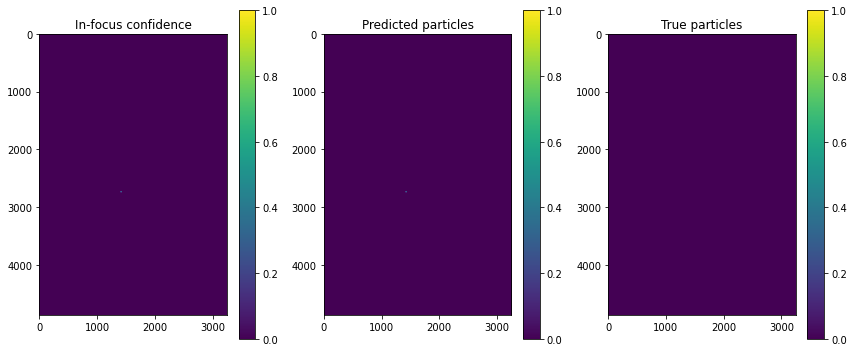

Plane: 9 at z: 0.015656 plane_f1: 0.9795 holo_f1: 0.6174 plane_csi: 1.0000 holo_csi: 0.4622:   1%|▏         | 13/1000 [02:35<3:53:22, 14.19s/it]

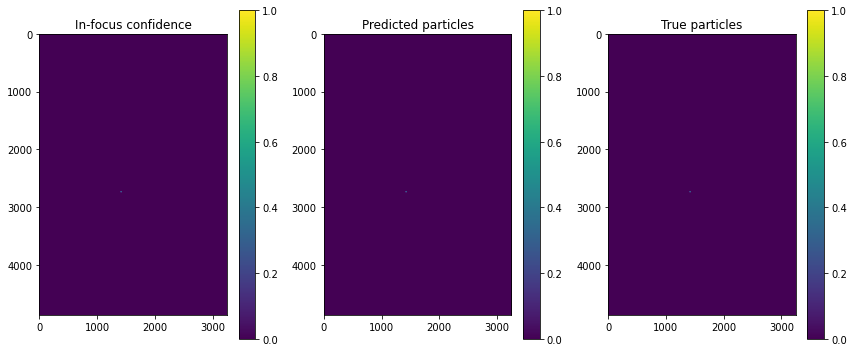

Plane: 10 at z: 0.015799999999999998 plane_f1: nan holo_f1: 0.5570 plane_csi: 0.0000 holo_csi: 0.3991:   2%|▏         | 15/1000 [02:51<3:08:20, 11.47s/it]

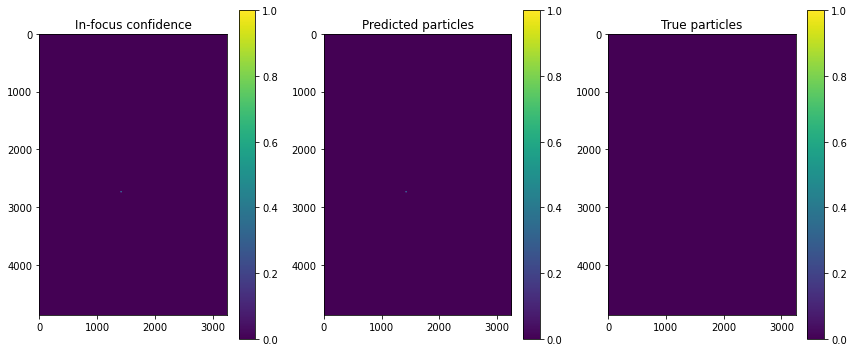

Plane: 11 at z: 0.015944 plane_f1: nan holo_f1: 0.5288 plane_csi: 0.0000 holo_csi: 0.3722:   2%|▏         | 16/1000 [03:07<3:28:03, 12.69s/it]            

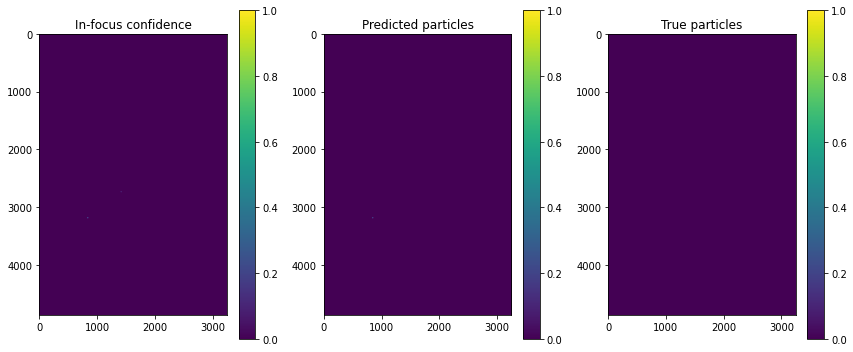

Plane: 12 at z: 0.016087999999999998 plane_f1: 0.9716 holo_f1: 0.5689 plane_csi: 0.9914 holo_csi: 0.4117:   2%|▏         | 17/1000 [03:22<3:42:14, 13.57s/it]

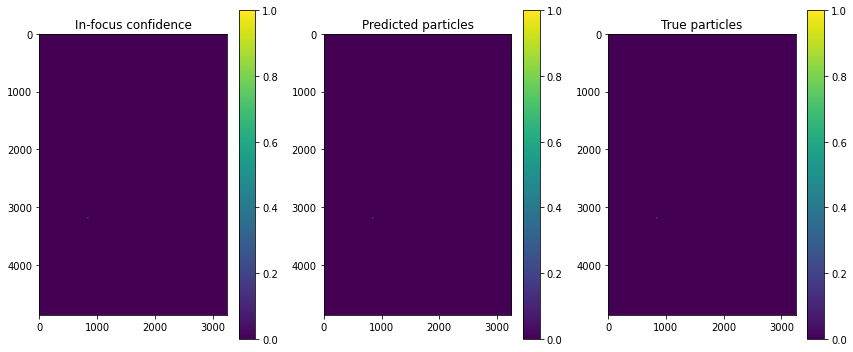

Plane: 13 at z: 0.016232 plane_f1: nan holo_f1: 0.5689 plane_csi: 0.0000 holo_csi: 0.4117:   2%|▏         | 18/1000 [03:38<3:52:03, 14.18s/it]               

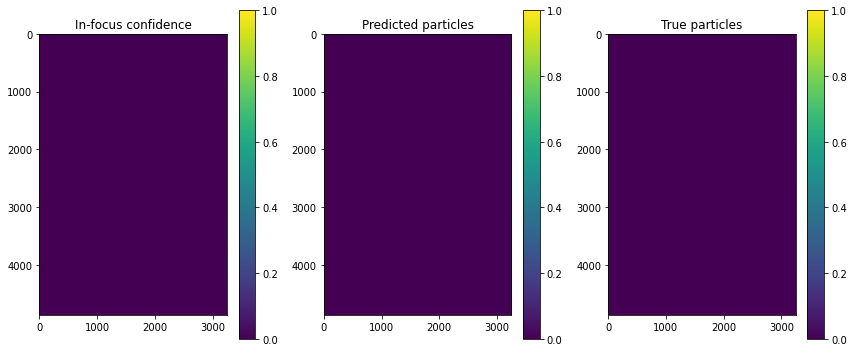

Plane: 14 at z: 0.016375999999999998 plane_f1: nan holo_f1: 0.5637 plane_csi: 0.0000 holo_csi: 0.4090:   2%|▏         | 19/1000 [03:54<3:59:14, 14.63s/it]

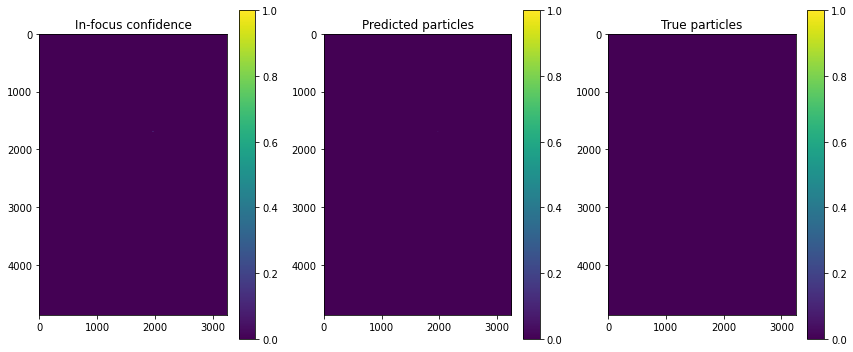

Plane: 15 at z: 0.01652 plane_f1: 0.9730 holo_f1: 0.6009 plane_csi: 1.0000 holo_csi: 0.4474:   2%|▏         | 21/1000 [04:10<3:12:20, 11.79s/it]          

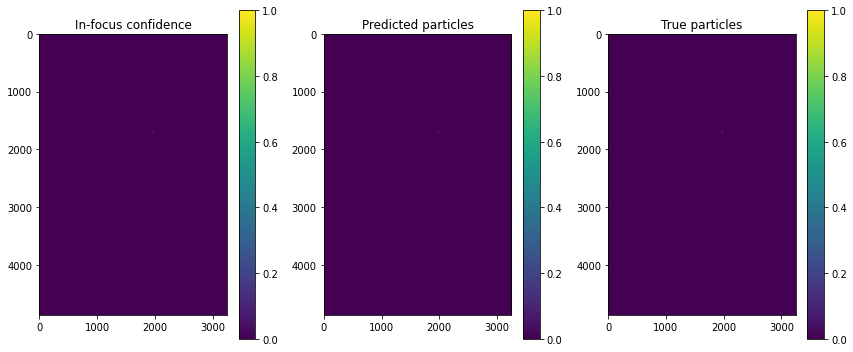

Plane: 16 at z: 0.016663999999999998 plane_f1: nan holo_f1: 0.5985 plane_csi: 0.0000 holo_csi: 0.4458:   2%|▏         | 22/1000 [04:25<3:31:44, 12.99s/it]

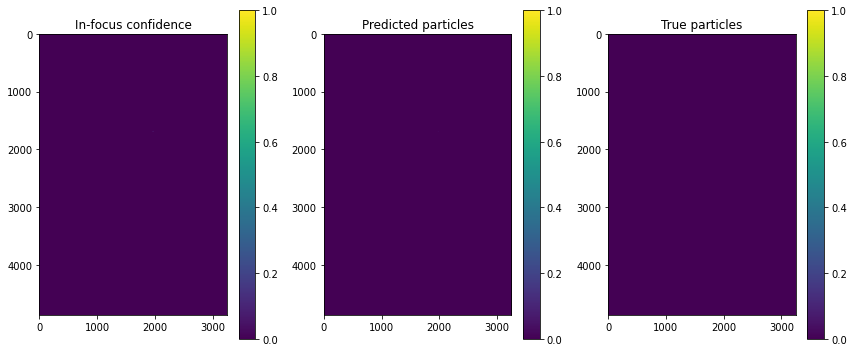

Plane: 17 at z: 0.016808 plane_f1: nan holo_f1: 0.5985 plane_csi: 0.0000 holo_csi: 0.4458:   2%|▏         | 23/1000 [04:41<3:45:36, 13.86s/it]            

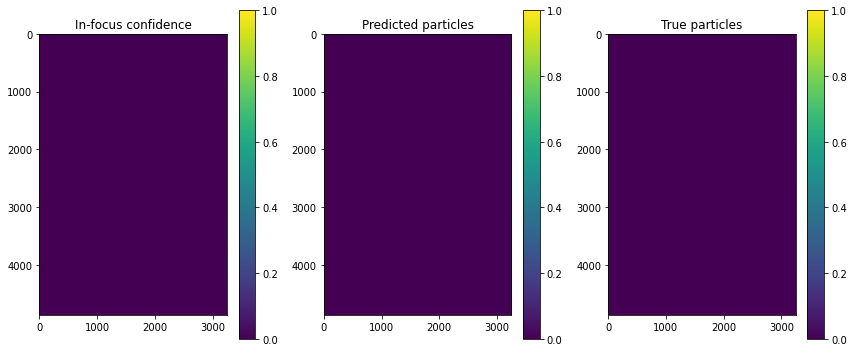

Plane: 18 at z: 0.016952 plane_f1: nan holo_f1: 0.5985 plane_csi: 0.0000 holo_csi: 0.4458:   2%|▏         | 24/1000 [04:57<3:54:31, 14.42s/it]

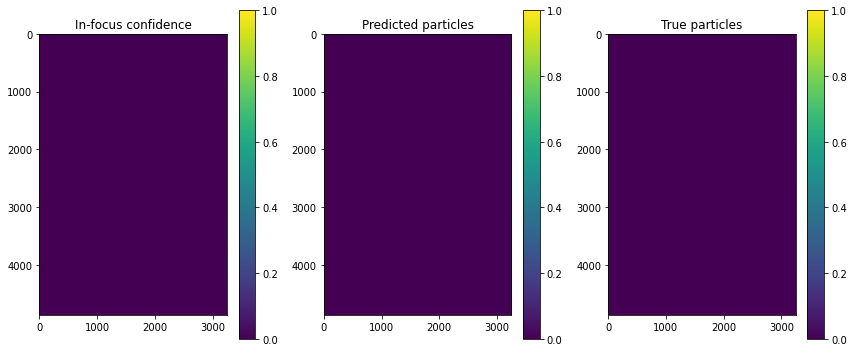

Plane: 19 at z: 0.017096 plane_f1: nan holo_f1: 0.5977 plane_csi: 0.0000 holo_csi: 0.4458:   2%|▎         | 25/1000 [05:13<4:01:04, 14.84s/it]

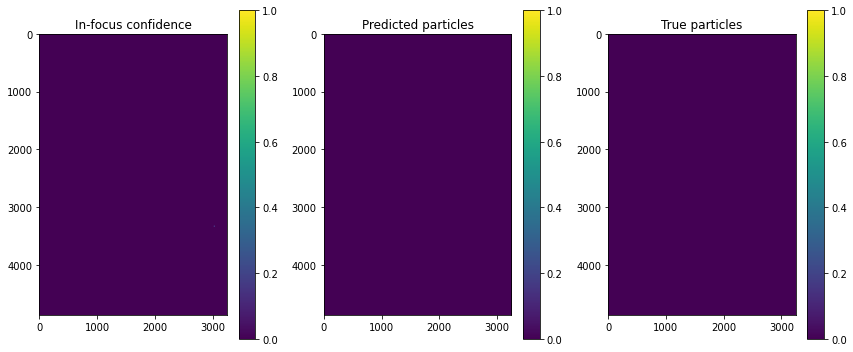

Plane: 20 at z: 0.01724 plane_f1: 0.9459 holo_f1: 0.6791 plane_csi: 0.9532 holo_csi: 0.5362:   3%|▎         | 26/1000 [05:29<4:06:45, 15.20s/it]

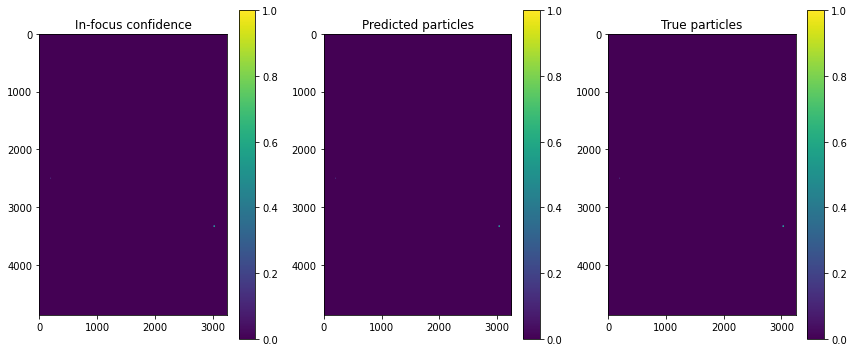

Plane: 21 at z: 0.017384 plane_f1: nan holo_f1: 0.6066 plane_csi: 0.0000 holo_csi: 0.4528:   3%|▎         | 28/1000 [05:44<3:13:33, 11.95s/it]  

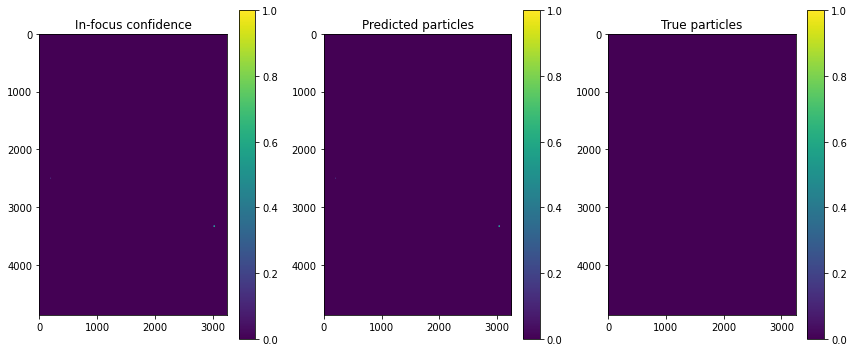

Plane: 22 at z: 0.017528 plane_f1: nan holo_f1: 0.5543 plane_csi: 0.0000 holo_csi: 0.3980:   3%|▎         | 29/1000 [06:00<3:30:46, 13.02s/it]

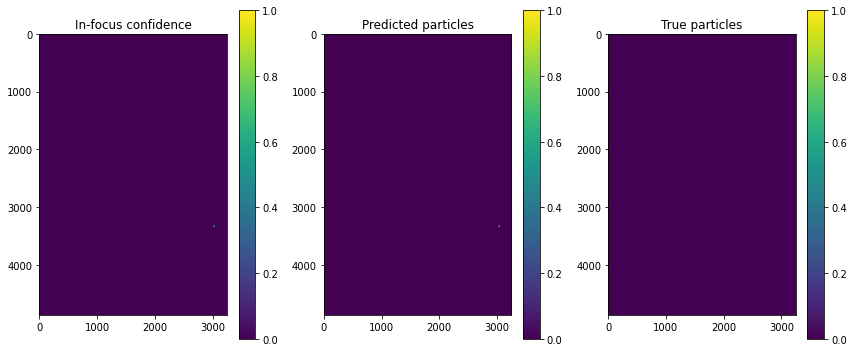

Plane: 23 at z: 0.017672 plane_f1: nan holo_f1: 0.5149 plane_csi: 0.0000 holo_csi: 0.3594:   3%|▎         | 30/1000 [06:15<3:42:36, 13.77s/it]

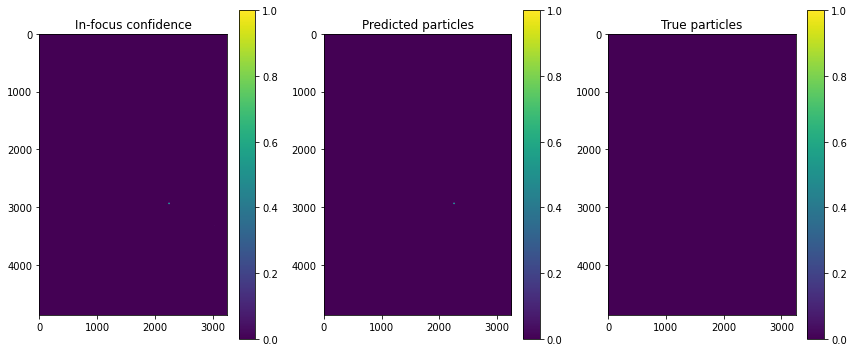

Plane: 24 at z: 0.017816 plane_f1: 0.9742 holo_f1: 0.5766 plane_csi: 0.9921 holo_csi: 0.4200:   3%|▎         | 31/1000 [06:31<3:52:17, 14.38s/it]

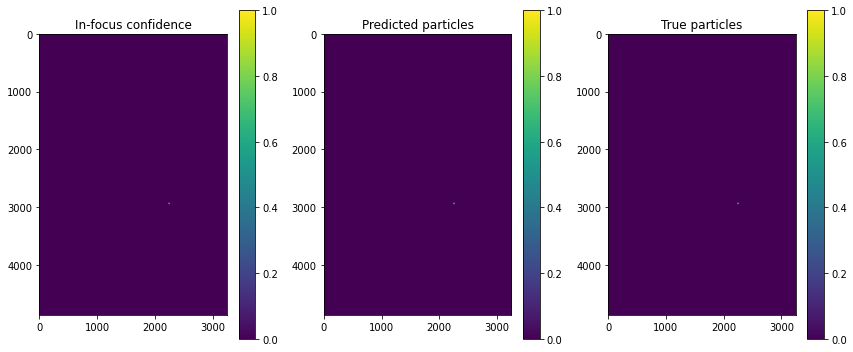

Plane: 25 at z: 0.01796 plane_f1: nan holo_f1: 0.5410 plane_csi: 0.0000 holo_csi: 0.3840:   3%|▎         | 32/1000 [06:47<3:59:17, 14.83s/it]    

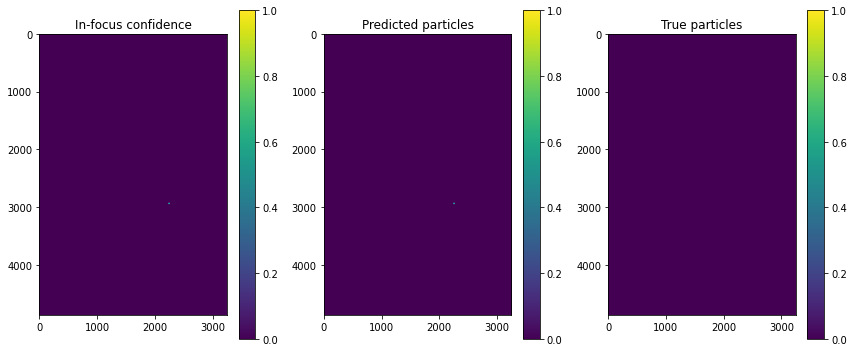

Plane: 26 at z: 0.018104 plane_f1: nan holo_f1: 0.5410 plane_csi: 0.0000 holo_csi: 0.3840:   3%|▎         | 33/1000 [07:03<4:03:15, 15.09s/it]

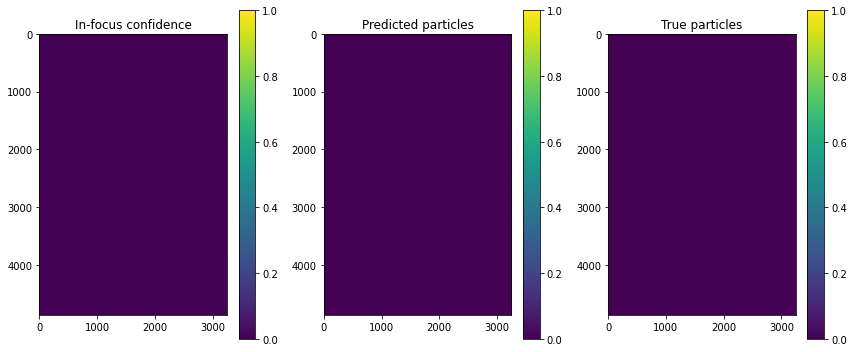

Plane: 27 at z: 0.018248 plane_f1: nan holo_f1: 0.5410 plane_csi: 0.0000 holo_csi: 0.3840:   3%|▎         | 34/1000 [07:18<4:05:22, 15.24s/it]

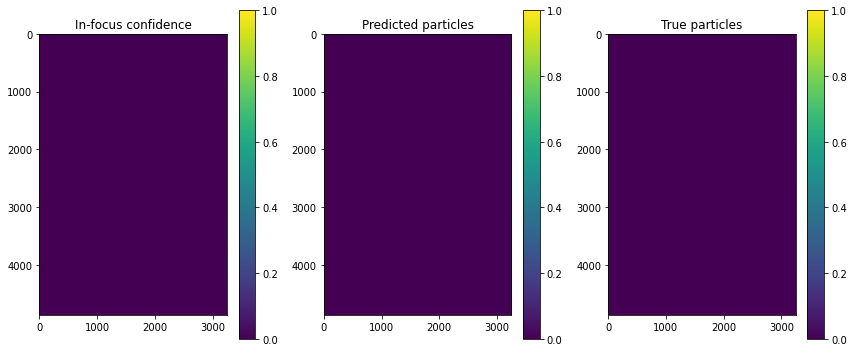

Plane: 28 at z: 0.018392 plane_f1: nan holo_f1: 0.5410 plane_csi: 0.0000 holo_csi: 0.3840:   4%|▎         | 36/1000 [07:34<3:12:02, 11.95s/it]

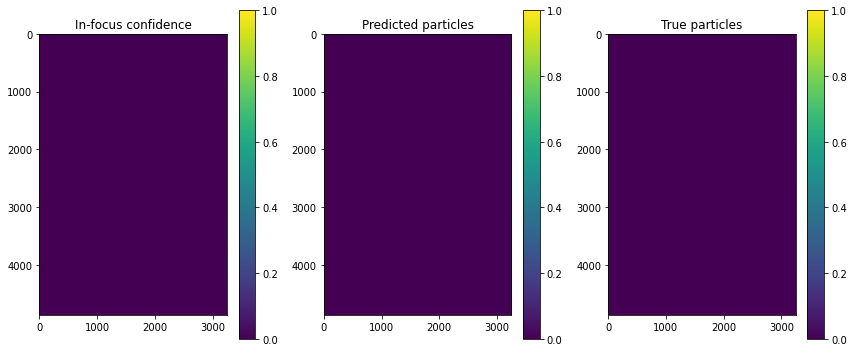

Plane: 29 at z: 0.018536 plane_f1: 0.9641 holo_f1: 0.5536 plane_csi: 0.9681 holo_csi: 0.3965:   4%|▎         | 37/1000 [07:50<3:29:18, 13.04s/it]

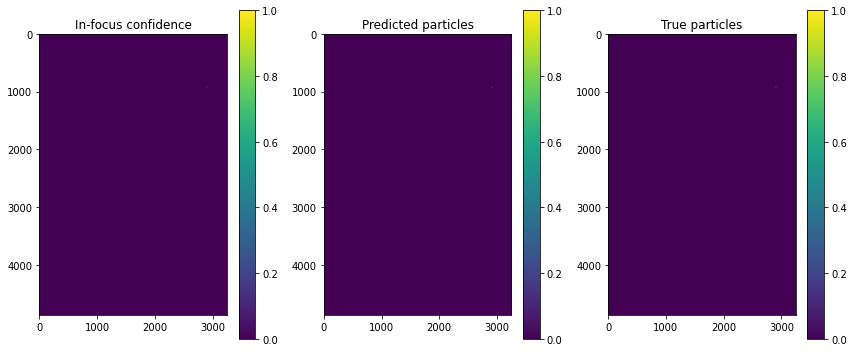

Plane: 30 at z: 0.01868 plane_f1: nan holo_f1: 0.5464 plane_csi: 0.0000 holo_csi: 0.3893:   4%|▍         | 38/1000 [08:05<3:41:32, 13.82s/it]    

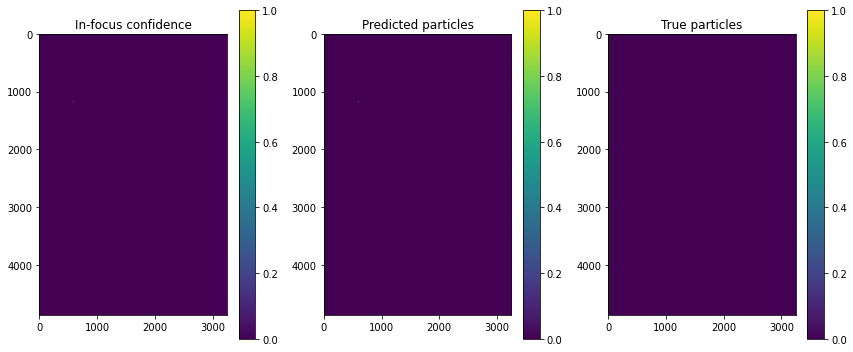

Plane: 31 at z: 0.018824 plane_f1: 0.8512 holo_f1: 0.5549 plane_csi: 0.7723 holo_csi: 0.3977:   4%|▍         | 39/1000 [08:21<3:50:36, 14.40s/it]

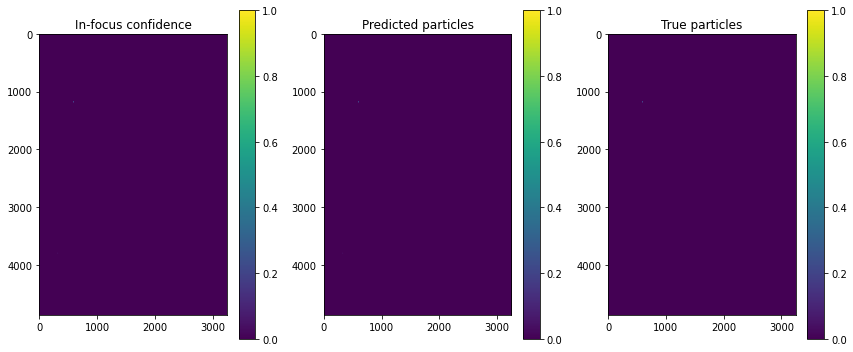

Plane: 32 at z: 0.018968 plane_f1: 0.9602 holo_f1: 0.5576 plane_csi: 1.0000 holo_csi: 0.4003:   4%|▍         | 40/1000 [08:37<3:56:15, 14.77s/it]

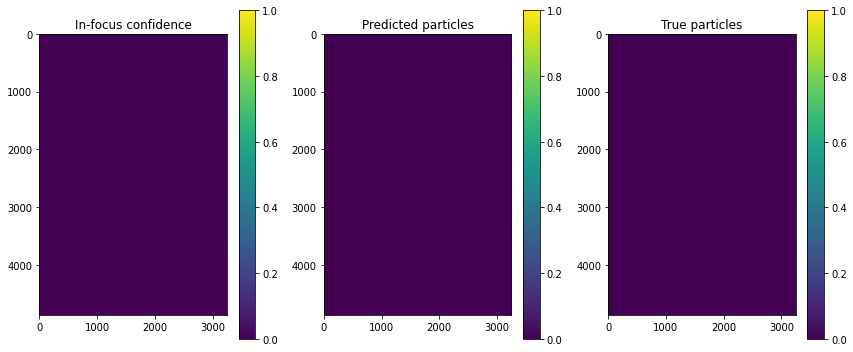

Plane: 33 at z: 0.019112 plane_f1: nan holo_f1: 0.5576 plane_csi: 0.0000 holo_csi: 0.4003:   4%|▍         | 41/1000 [08:52<4:00:16, 15.03s/it]   

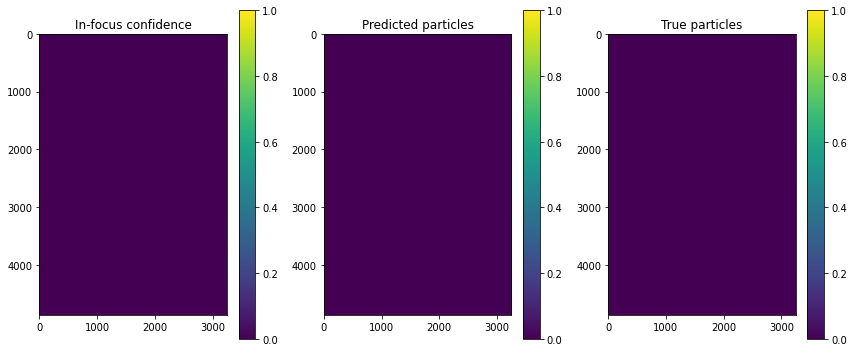

Plane: 34 at z: 0.019256 plane_f1: nan holo_f1: 0.5576 plane_csi: 0.0000 holo_csi: 0.4003:   4%|▍         | 42/1000 [09:08<4:01:38, 15.13s/it]

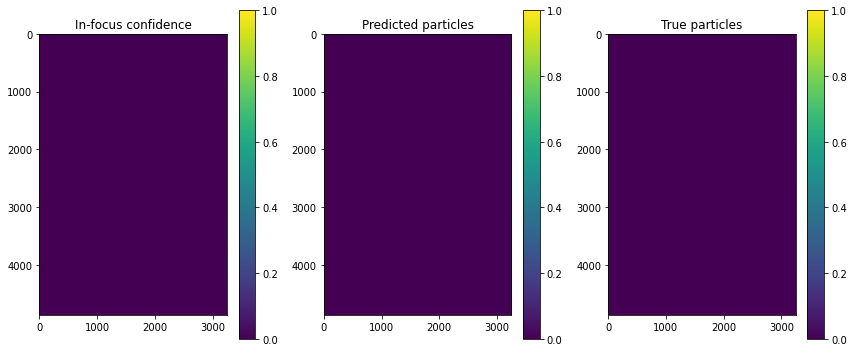

Plane: 35 at z: 0.0194 plane_f1: nan holo_f1: 0.5576 plane_csi: 0.0000 holo_csi: 0.4003:   4%|▍         | 43/1000 [09:23<4:02:33, 15.21s/it]  

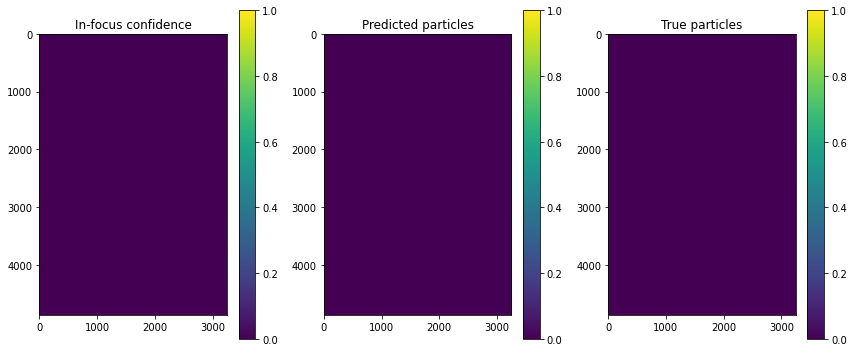

Plane: 36 at z: 0.019544 plane_f1: 0.9459 holo_f1: 0.5981 plane_csi: 0.9364 holo_csi: 0.4420:   4%|▍         | 45/1000 [09:39<3:10:41, 11.98s/it]

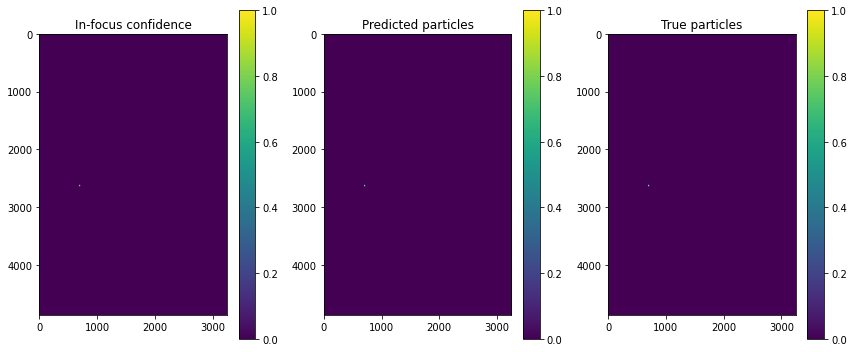

Plane: 37 at z: 0.019688 plane_f1: nan holo_f1: 0.5682 plane_csi: 0.0000 holo_csi: 0.4106:   5%|▍         | 46/1000 [09:54<3:27:33, 13.05s/it]   

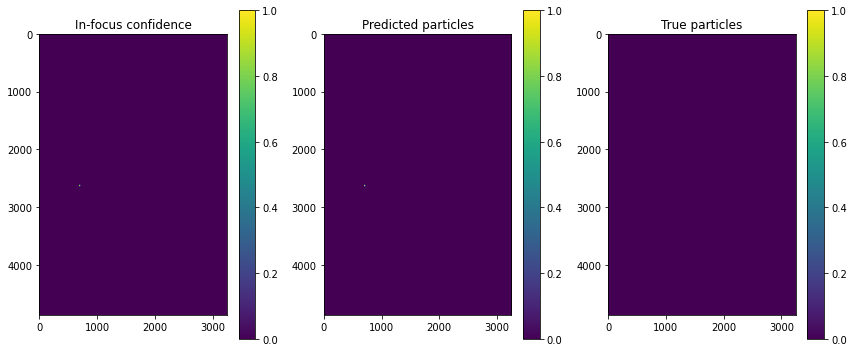

Plane: 38 at z: 0.019832 plane_f1: nan holo_f1: 0.5605 plane_csi: 0.0000 holo_csi: 0.4042:   5%|▍         | 47/1000 [10:10<3:41:12, 13.93s/it]

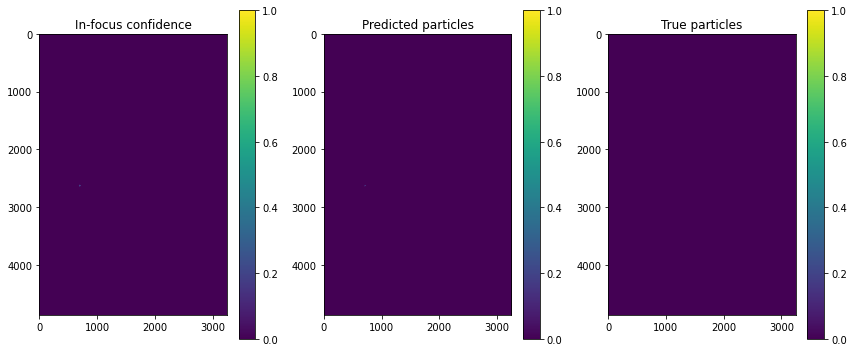

Plane: 39 at z: 0.019976 plane_f1: nan holo_f1: 0.5605 plane_csi: 0.0000 holo_csi: 0.4042:   5%|▍         | 48/1000 [10:26<3:50:06, 14.50s/it]

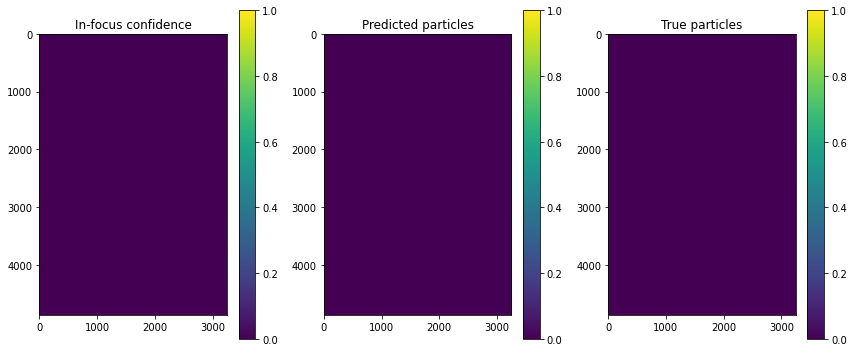

Plane: 40 at z: 0.02012 plane_f1: nan holo_f1: 0.5496 plane_csi: 0.0000 holo_csi: 0.3932:   5%|▍         | 49/1000 [10:42<3:56:44, 14.94s/it] 

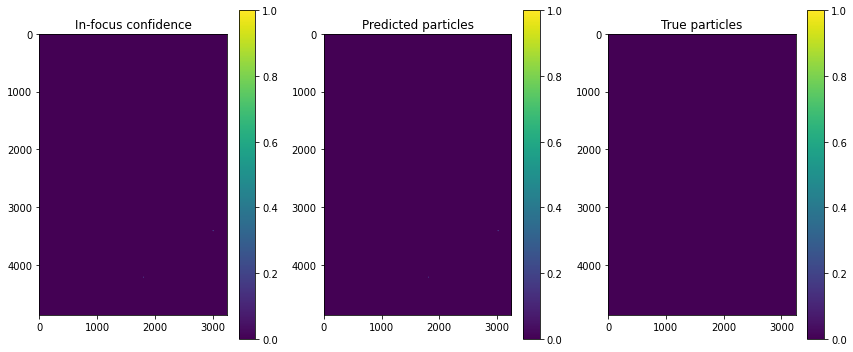

Plane: 41 at z: 0.020264 plane_f1: 0.9327 holo_f1: 0.5644 plane_csi: 0.9207 holo_csi: 0.4082:   5%|▌         | 50/1000 [10:58<4:00:31, 15.19s/it]

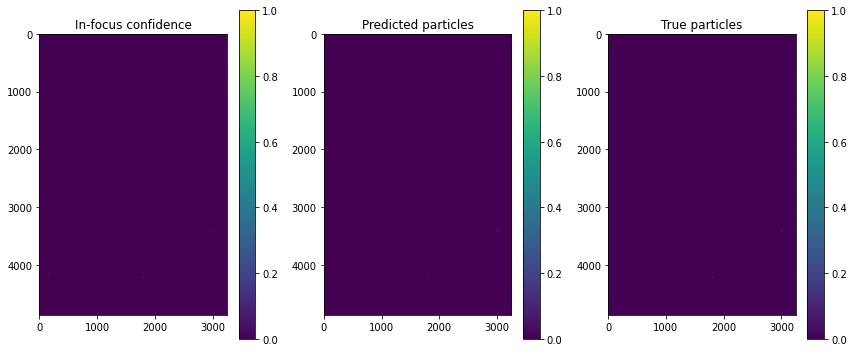

Plane: 42 at z: 0.020408 plane_f1: 0.4397 holo_f1: 0.5615 plane_csi: 0.3007 holo_csi: 0.4055:   5%|▌         | 51/1000 [11:14<4:03:04, 15.37s/it]

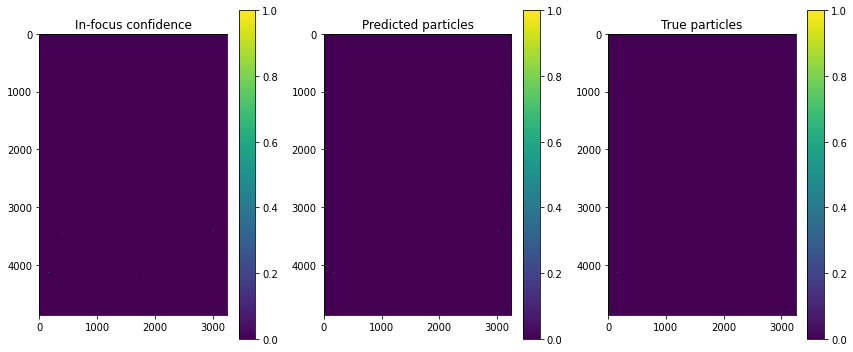

Plane: 43 at z: 0.020551999999999997 plane_f1: nan holo_f1: 0.5510 plane_csi: 0.0000 holo_csi: 0.3949:   5%|▌         | 52/1000 [11:29<4:04:34, 15.48s/it]

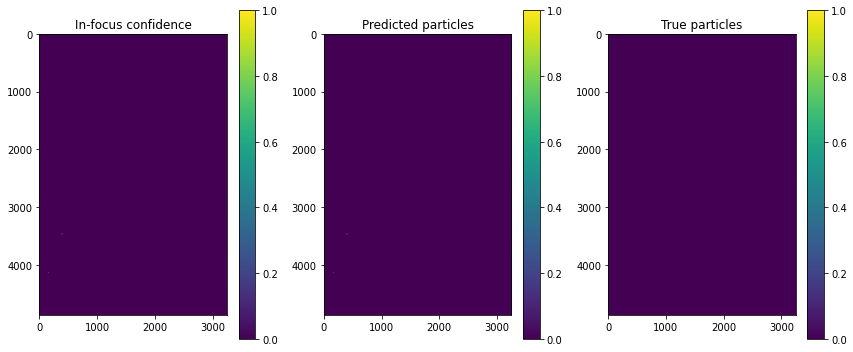

Plane: 44 at z: 0.020696 plane_f1: 0.9697 holo_f1: 0.5629 plane_csi: 0.9921 holo_csi: 0.4068:   5%|▌         | 53/1000 [11:45<4:06:54, 15.64s/it]         

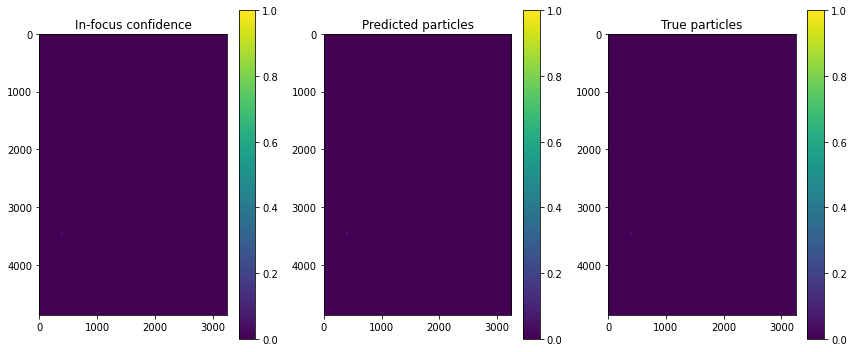

Plane: 45 at z: 0.020839999999999997 plane_f1: nan holo_f1: 0.5629 plane_csi: 0.0000 holo_csi: 0.4068:   6%|▌         | 55/1000 [12:01<3:13:19, 12.27s/it]

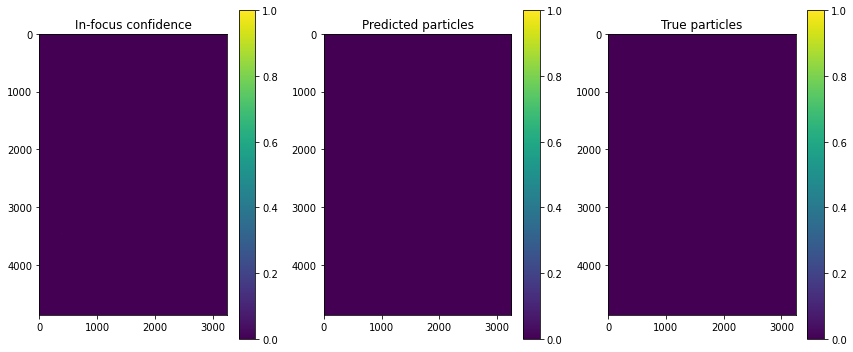

Plane: 46 at z: 0.020984 plane_f1: 0.9045 holo_f1: 0.5634 plane_csi: 1.0000 holo_csi: 0.4073:   6%|▌         | 56/1000 [12:17<3:31:02, 13.41s/it]         

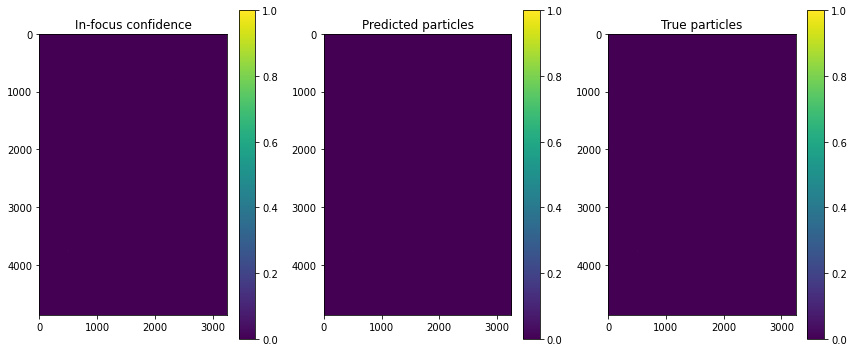

Plane: 47 at z: 0.021127999999999997 plane_f1: 0.9299 holo_f1: 0.6116 plane_csi: 0.9264 holo_csi: 0.4569:   6%|▌         | 57/1000 [12:33<3:43:02, 14.19s/it]

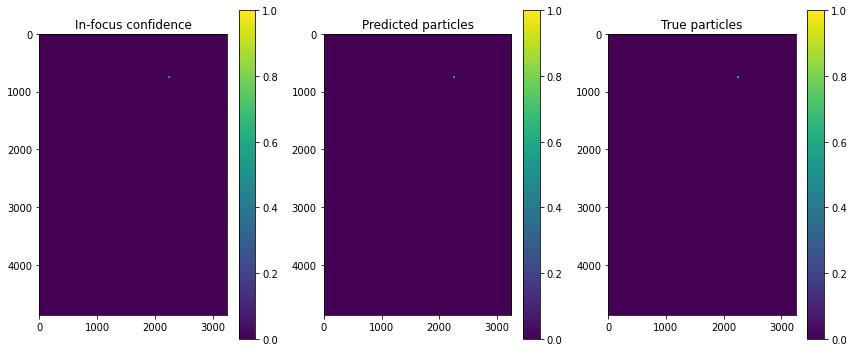

Plane: 48 at z: 0.021272 plane_f1: nan holo_f1: 0.5726 plane_csi: 0.0000 holo_csi: 0.4154:   6%|▌         | 58/1000 [12:49<3:50:23, 14.67s/it]               

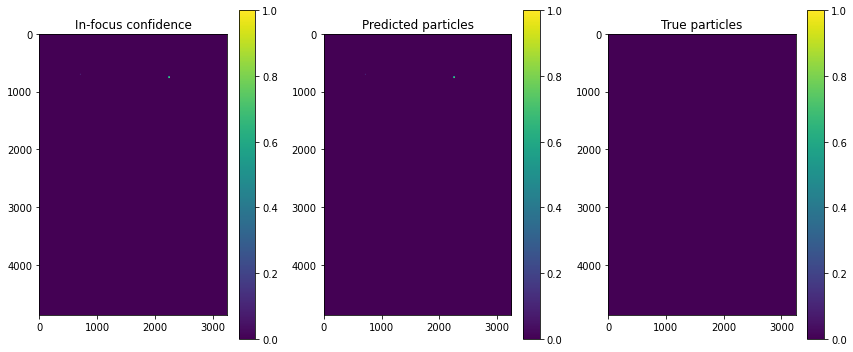

Plane: 49 at z: 0.021415999999999998 plane_f1: nan holo_f1: 0.5591 plane_csi: 0.0000 holo_csi: 0.4042:   6%|▌         | 59/1000 [13:05<3:55:03, 14.99s/it]

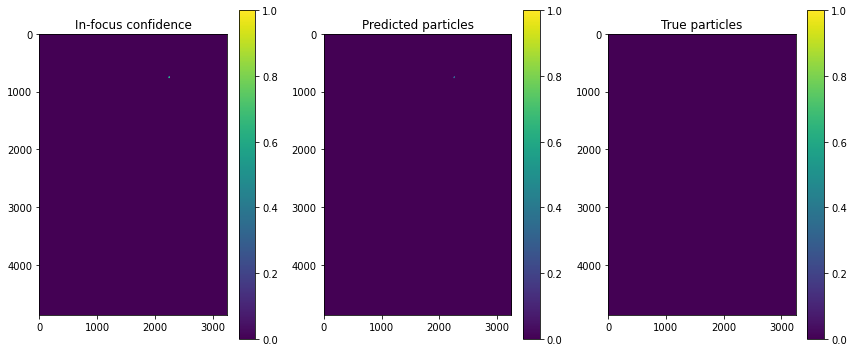

Plane: 50 at z: 0.02156 plane_f1: nan holo_f1: 0.5591 plane_csi: 0.0000 holo_csi: 0.4042:   6%|▌         | 60/1000 [13:20<3:57:53, 15.18s/it]             

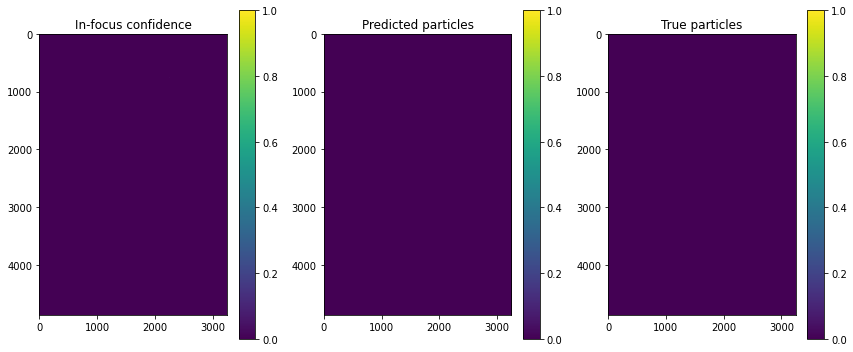

Plane: 51 at z: 0.021703999999999998 plane_f1: nan holo_f1: 0.5591 plane_csi: 0.0000 holo_csi: 0.4042:   6%|▌         | 61/1000 [13:36<4:01:18, 15.42s/it]

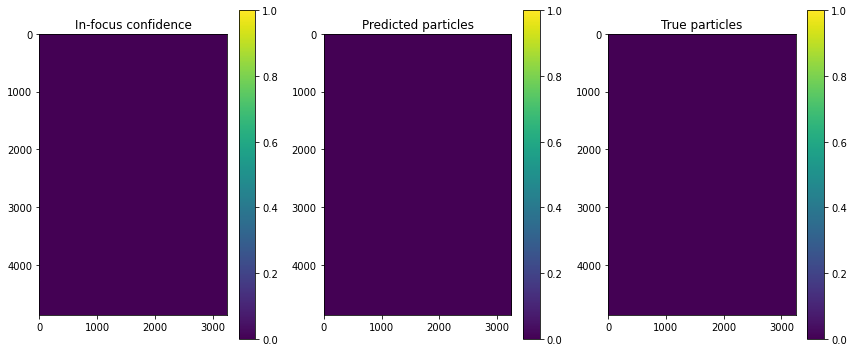

Plane: 52 at z: 0.021848 plane_f1: nan holo_f1: 0.5574 plane_csi: 0.0000 holo_csi: 0.4026:   6%|▌         | 62/1000 [13:52<4:03:42, 15.59s/it]            

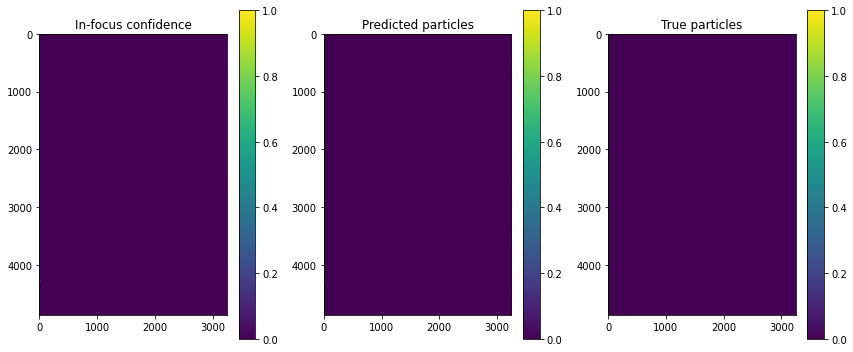

Plane: 53 at z: 0.021991999999999998 plane_f1: 0.9538 holo_f1: 0.5727 plane_csi: 0.9478 holo_csi: 0.4181:   6%|▋         | 63/1000 [14:09<4:06:10, 15.76s/it]

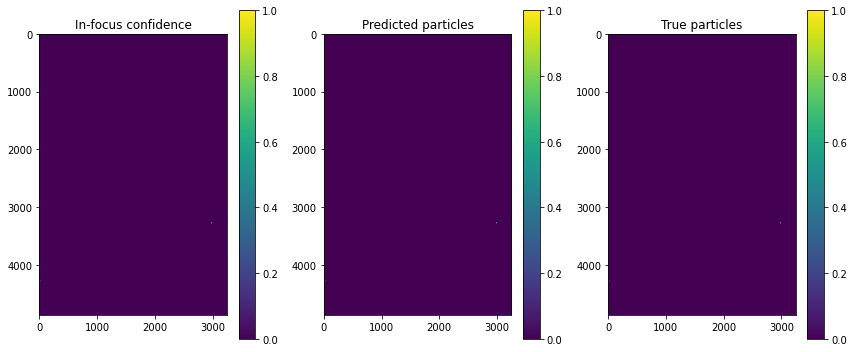

Plane: 54 at z: 0.022136 plane_f1: nan holo_f1: 0.5445 plane_csi: 0.0000 holo_csi: 0.3893:   6%|▋         | 64/1000 [14:24<4:05:13, 15.72s/it]               

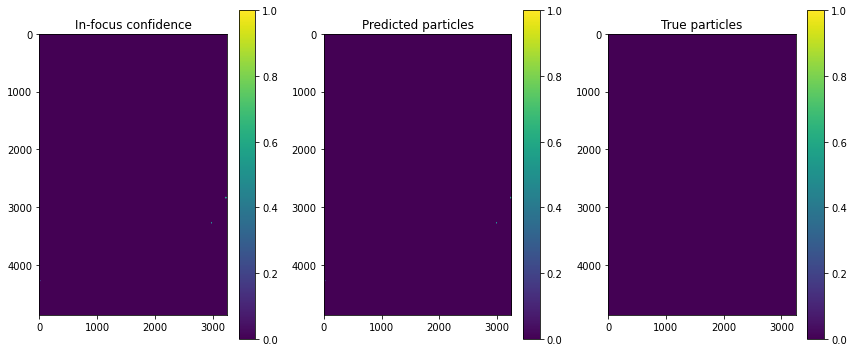

Plane: 55 at z: 0.022279999999999998 plane_f1: nan holo_f1: 0.5277 plane_csi: 0.0000 holo_csi: 0.3728:   7%|▋         | 66/1000 [14:40<3:10:30, 12.24s/it]

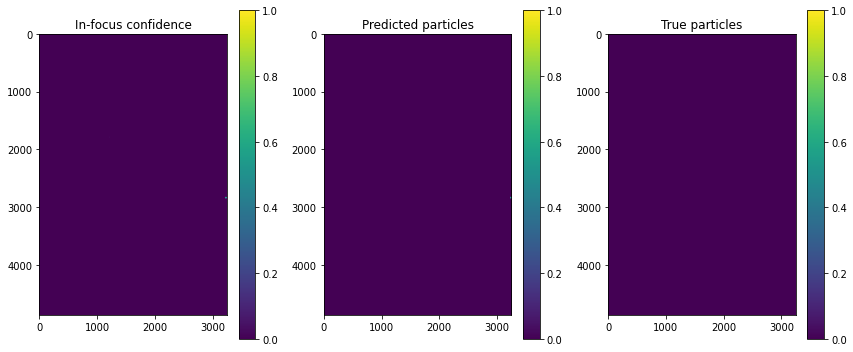

Plane: 56 at z: 0.022424 plane_f1: 0.9418 holo_f1: 0.5559 plane_csi: 0.9374 holo_csi: 0.4003:   7%|▋         | 67/1000 [14:56<3:27:50, 13.37s/it]         

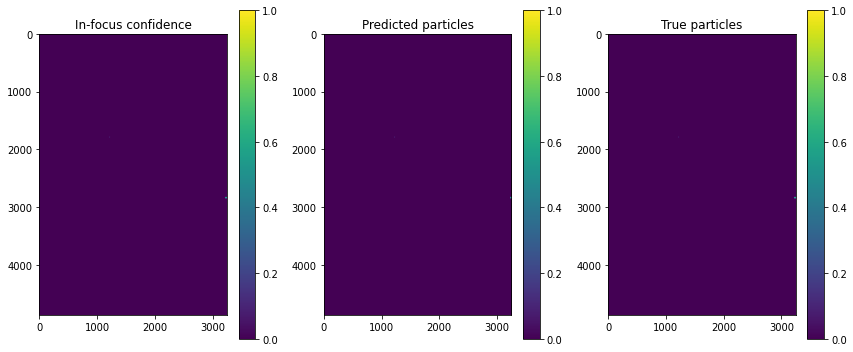

Plane: 57 at z: 0.022567999999999998 plane_f1: nan holo_f1: 0.5401 plane_csi: 0.0000 holo_csi: 0.3846:   7%|▋         | 68/1000 [15:12<3:39:49, 14.15s/it]

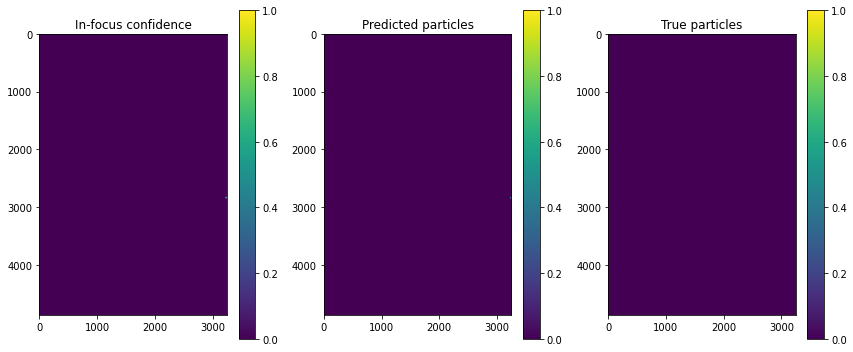

Plane: 58 at z: 0.022712 plane_f1: nan holo_f1: 0.5401 plane_csi: 0.0000 holo_csi: 0.3846:   7%|▋         | 69/1000 [15:28<3:47:09, 14.64s/it]            

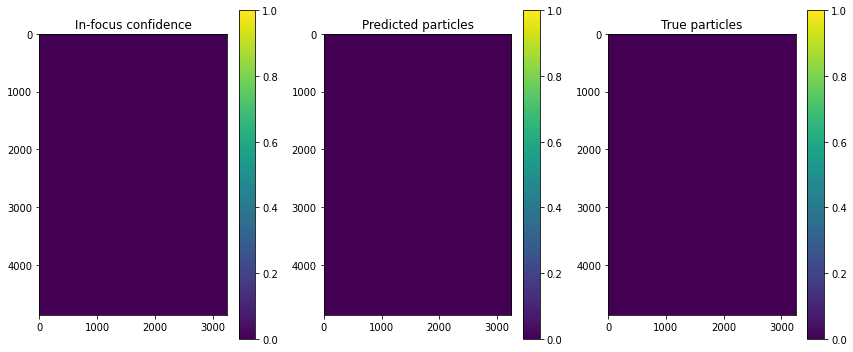

Plane: 59 at z: 0.022855999999999998 plane_f1: nan holo_f1: 0.5377 plane_csi: 0.0000 holo_csi: 0.3822:   7%|▋         | 70/1000 [15:44<3:53:03, 15.04s/it]

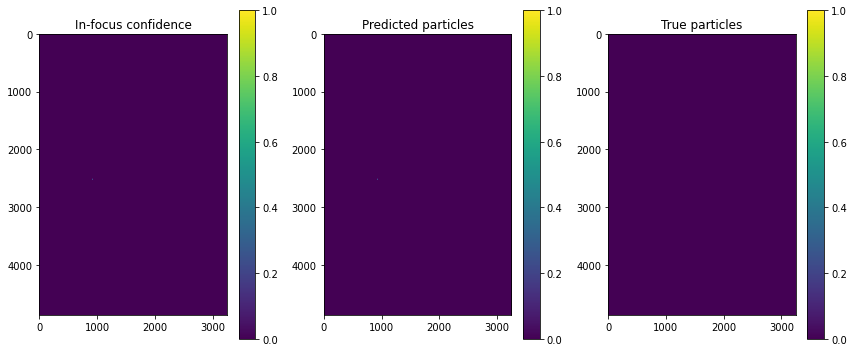

Plane: 60 at z: 0.023 plane_f1: 0.3439 holo_f1: 0.5330 plane_csi: 0.2153 holo_csi: 0.3776:   7%|▋         | 71/1000 [15:59<3:55:46, 15.23s/it]            

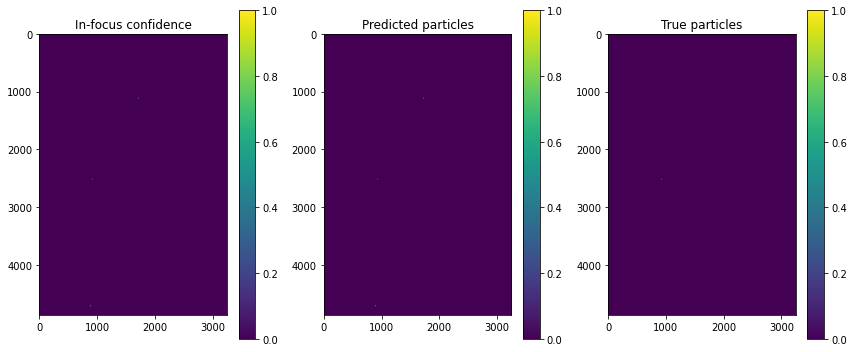

Plane: 61 at z: 0.023143999999999998 plane_f1: 0.9601 holo_f1: 0.5522 plane_csi: 0.9625 holo_csi: 0.3964:   7%|▋         | 72/1000 [16:15<3:58:07, 15.40s/it]

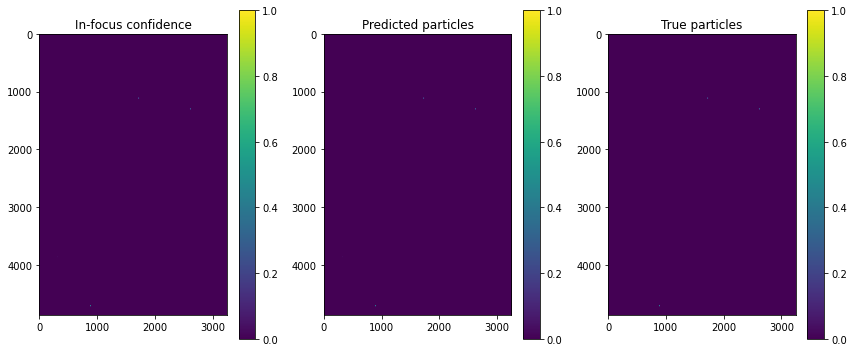

Plane: 62 at z: 0.023288 plane_f1: 0.0487 holo_f1: 0.5441 plane_csi: 0.0289 holo_csi: 0.3884:   7%|▋         | 73/1000 [16:31<3:59:59, 15.53s/it]            

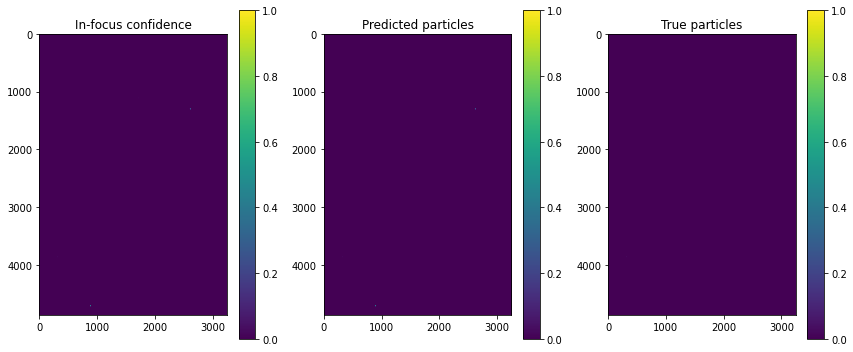

Plane: 63 at z: 0.023431999999999998 plane_f1: 0.9724 holo_f1: 0.5603 plane_csi: 0.9901 holo_csi: 0.4044:   7%|▋         | 74/1000 [16:47<4:01:40, 15.66s/it]

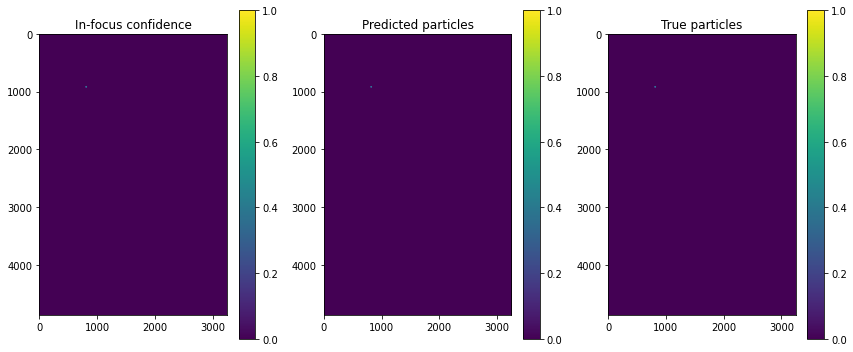

Plane: 64 at z: 0.023576 plane_f1: nan holo_f1: 0.5498 plane_csi: 0.0000 holo_csi: 0.3938:   8%|▊         | 75/1000 [17:03<4:01:54, 15.69s/it]               

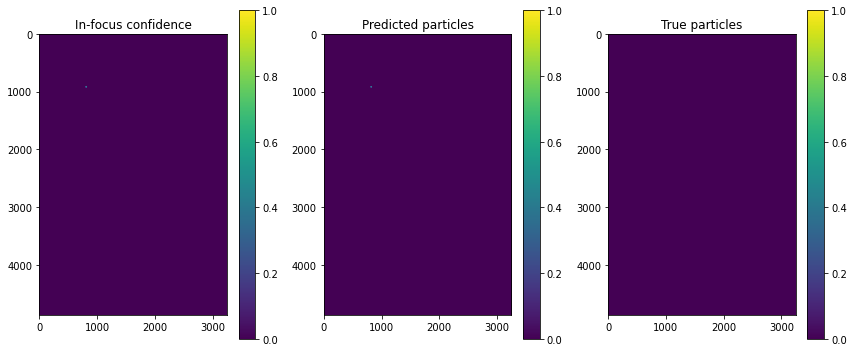

Plane: 65 at z: 0.023719999999999998 plane_f1: nan holo_f1: 0.5463 plane_csi: 0.0000 holo_csi: 0.3906:   8%|▊         | 76/1000 [17:19<4:02:14, 15.73s/it]

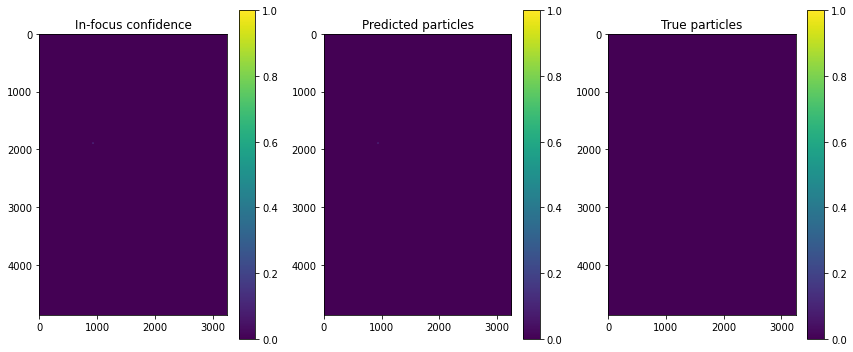

Plane: 66 at z: 0.023864 plane_f1: 0.4098 holo_f1: 0.5423 plane_csi: 0.2742 holo_csi: 0.3870:   8%|▊         | 78/1000 [17:34<3:08:37, 12.27s/it]         

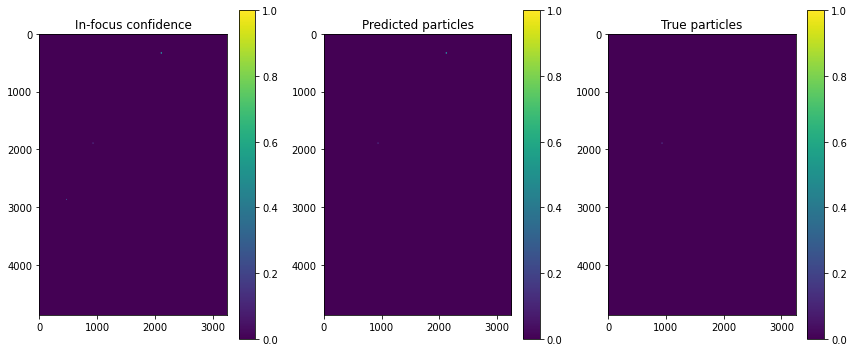

Plane: 67 at z: 0.024007999999999998 plane_f1: 0.8673 holo_f1: 0.5611 plane_csi: 0.7941 holo_csi: 0.4056:   8%|▊         | 79/1000 [17:50<3:24:32, 13.32s/it]

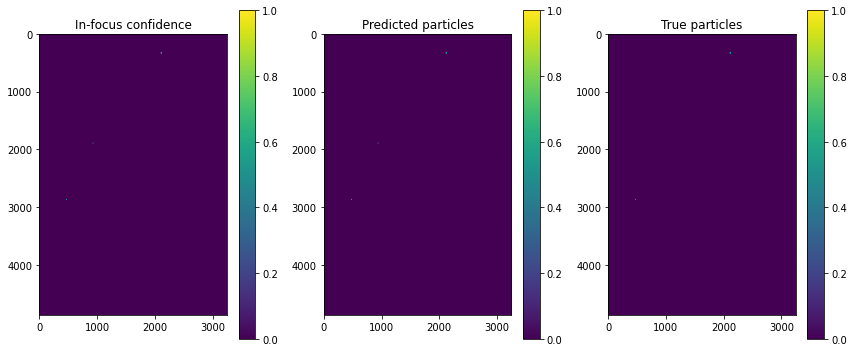

Plane: 68 at z: 0.024152 plane_f1: nan holo_f1: 0.5508 plane_csi: 0.0000 holo_csi: 0.3953:   8%|▊         | 80/1000 [18:06<3:34:52, 14.01s/it]               

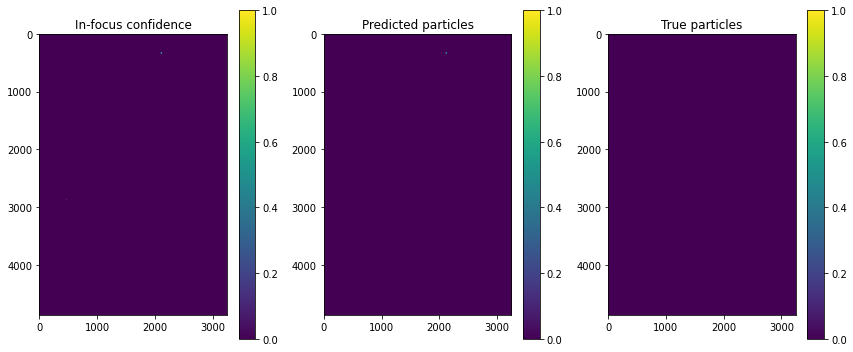

Plane: 69 at z: 0.024295999999999998 plane_f1: nan holo_f1: 0.5508 plane_csi: 0.0000 holo_csi: 0.3953:   8%|▊         | 81/1000 [18:21<3:41:57, 14.49s/it]

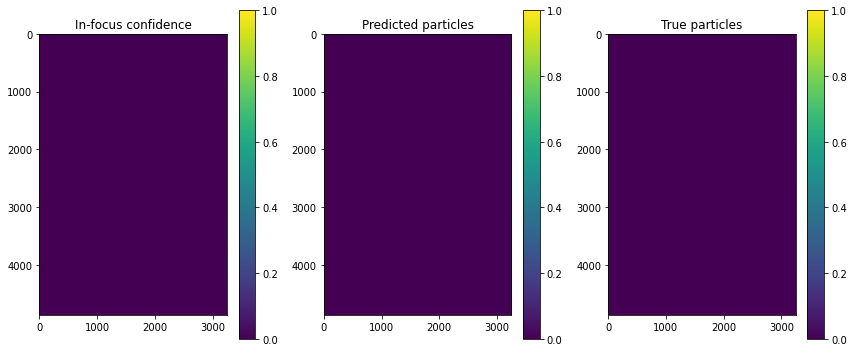

Plane: 70 at z: 0.02444 plane_f1: nan holo_f1: 0.5508 plane_csi: 0.0000 holo_csi: 0.3953:   8%|▊         | 82/1000 [18:37<3:47:49, 14.89s/it]             

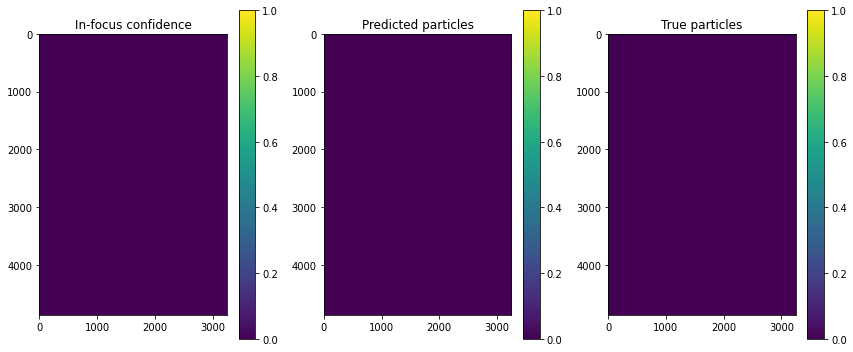

Plane: 71 at z: 0.024583999999999998 plane_f1: 0.9340 holo_f1: 0.5548 plane_csi: 0.9485 holo_csi: 0.3994:   8%|▊         | 83/1000 [18:53<3:51:29, 15.15s/it]

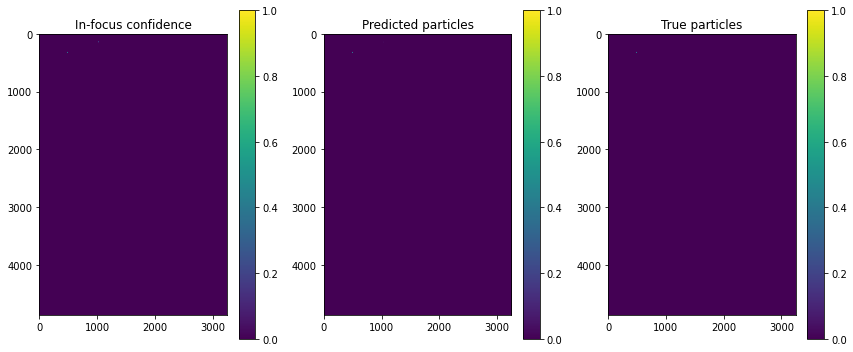

Plane: 72 at z: 0.024728 plane_f1: nan holo_f1: 0.5474 plane_csi: 0.0000 holo_csi: 0.3919:   8%|▊         | 84/1000 [19:09<3:55:05, 15.40s/it]               

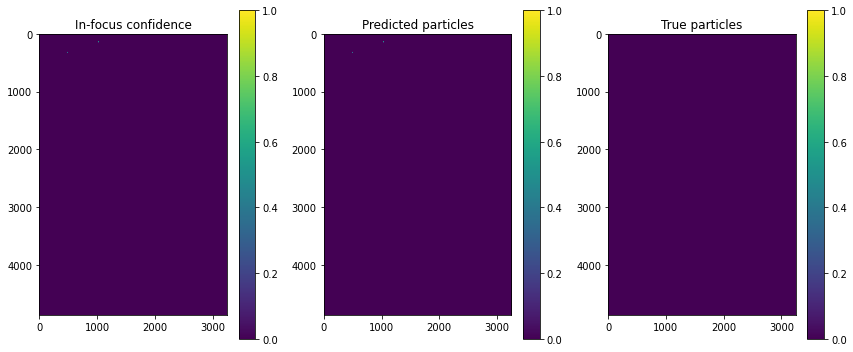

Plane: 73 at z: 0.024872 plane_f1: 0.6643 holo_f1: 0.5503 plane_csi: 0.5145 holo_csi: 0.3947:   8%|▊         | 85/1000 [19:25<3:56:00, 15.48s/it]

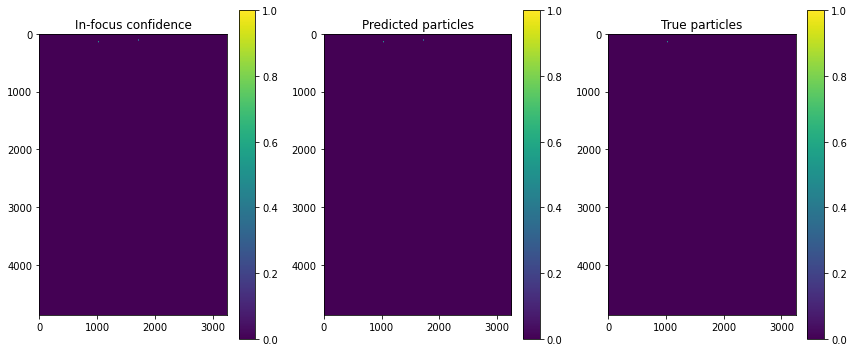

Plane: 74 at z: 0.025016 plane_f1: 0.7995 holo_f1: 0.5550 plane_csi: 0.7343 holo_csi: 0.3997:   9%|▊         | 86/1000 [19:41<3:57:34, 15.60s/it]

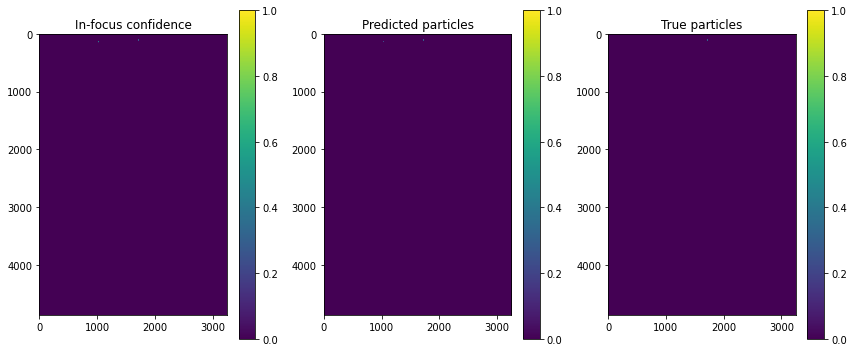

Plane: 75 at z: 0.02516 plane_f1: nan holo_f1: 0.5550 plane_csi: 0.0000 holo_csi: 0.3997:   9%|▊         | 87/1000 [19:56<3:57:20, 15.60s/it]    

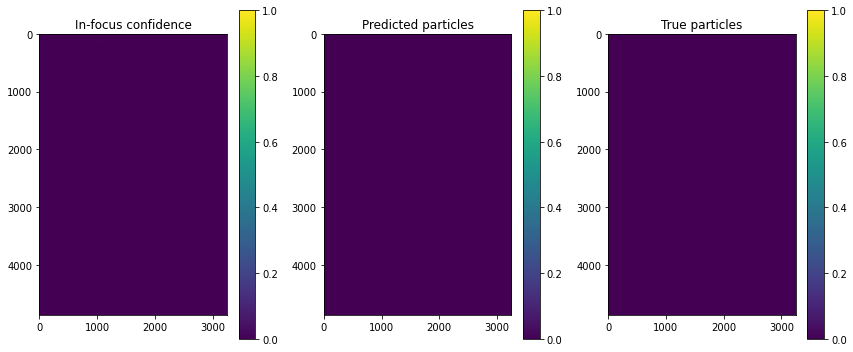

Plane: 76 at z: 0.025304 plane_f1: nan holo_f1: 0.5550 plane_csi: 0.0000 holo_csi: 0.3997:   9%|▉         | 88/1000 [20:12<3:58:17, 15.68s/it]

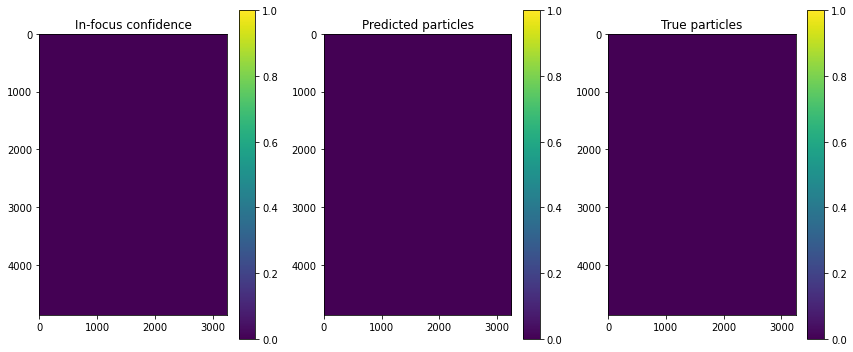

Plane: 77 at z: 0.025448 plane_f1: nan holo_f1: 0.5546 plane_csi: 0.0000 holo_csi: 0.3993:   9%|▉         | 89/1000 [20:28<3:58:31, 15.71s/it]

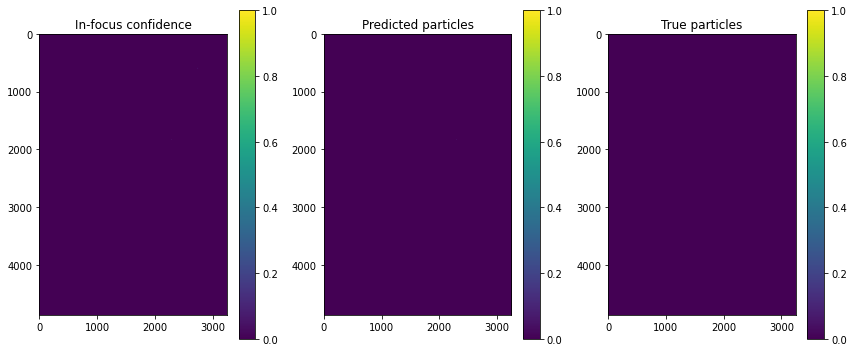

Plane: 78 at z: 0.025592 plane_f1: 0.9562 holo_f1: 0.5618 plane_csi: 0.9563 holo_csi: 0.4065:   9%|▉         | 91/1000 [20:44<3:06:18, 12.30s/it]

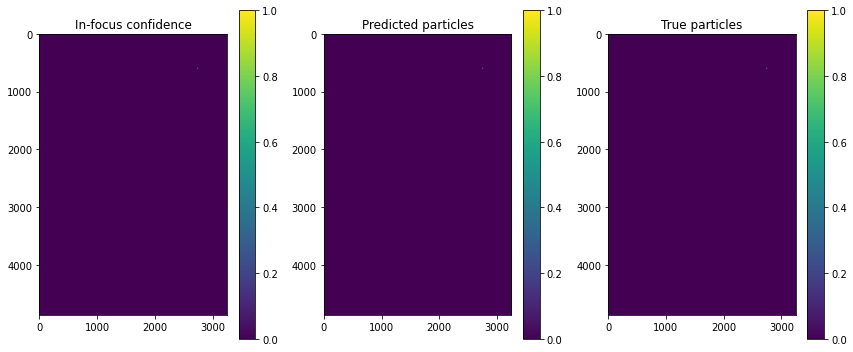

Plane: 79 at z: 0.025736 plane_f1: nan holo_f1: 0.5573 plane_csi: 0.0000 holo_csi: 0.4020:   9%|▉         | 92/1000 [21:00<3:22:13, 13.36s/it]   

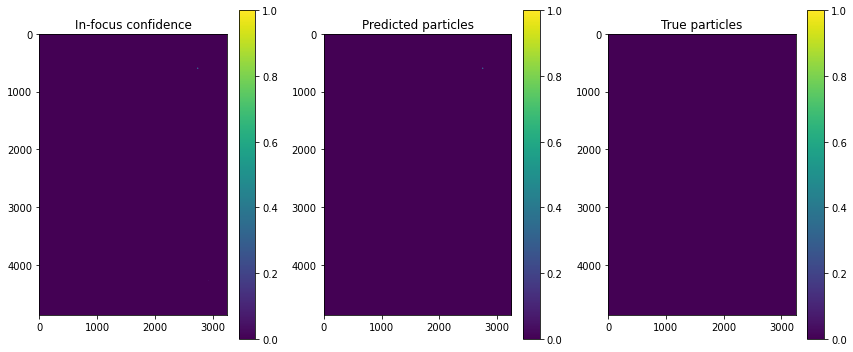

Plane: 80 at z: 0.025879 plane_f1: 0.9462 holo_f1: 0.5579 plane_csi: 0.9333 holo_csi: 0.4025:   9%|▉         | 93/1000 [21:15<3:32:47, 14.08s/it]

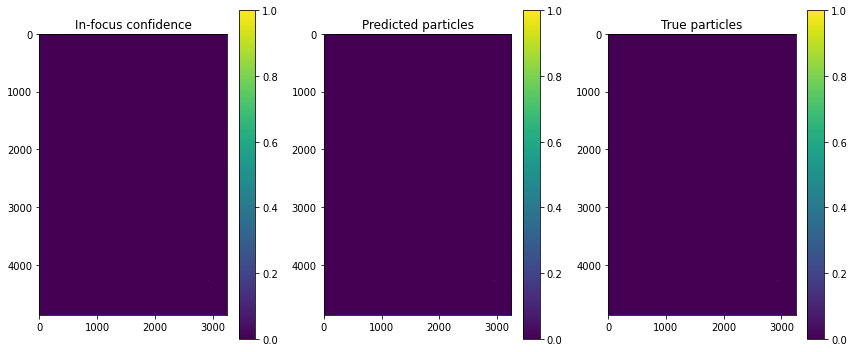

Plane: 81 at z: 0.026022999999999998 plane_f1: 0.7042 holo_f1: 0.5601 plane_csi: 0.7389 holo_csi: 0.4040:   9%|▉         | 94/1000 [21:31<3:39:59, 14.57s/it]

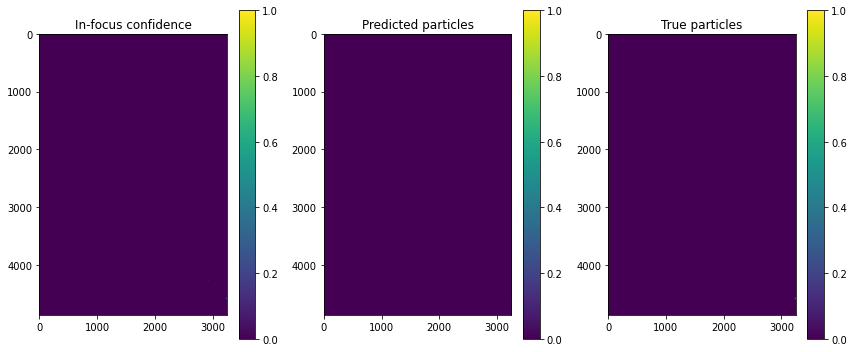

Plane: 82 at z: 0.026168 plane_f1: nan holo_f1: 0.5559 plane_csi: 0.0000 holo_csi: 0.3999:  10%|▉         | 95/1000 [21:47<3:45:25, 14.95s/it]               

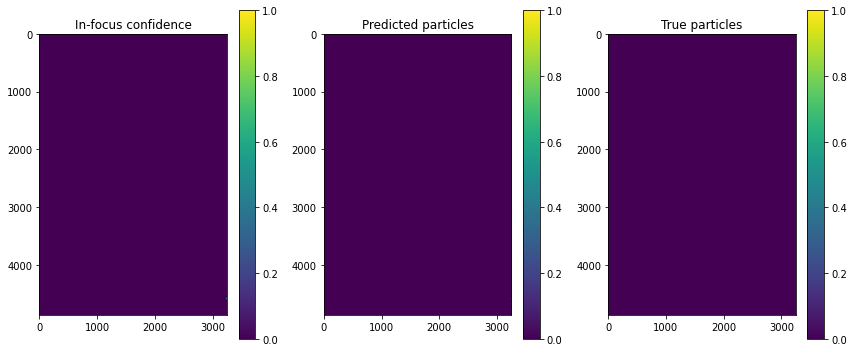

Plane: 83 at z: 0.026312 plane_f1: 0.4974 holo_f1: 0.5553 plane_csi: 0.3537 holo_csi: 0.3994:  10%|▉         | 96/1000 [22:03<3:48:52, 15.19s/it]

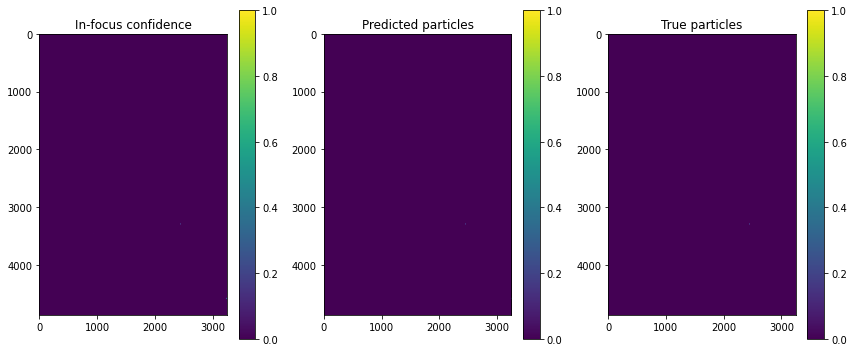

Plane: 84 at z: 0.026455 plane_f1: nan holo_f1: 0.5537 plane_csi: 0.0000 holo_csi: 0.3978:  10%|▉         | 97/1000 [22:19<3:51:46, 15.40s/it]   

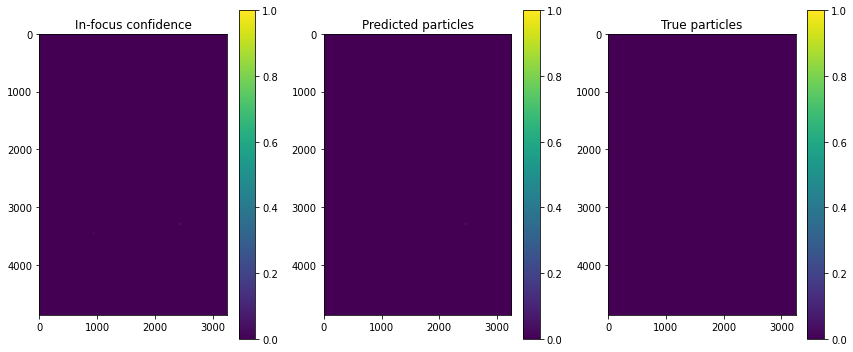

Plane: 85 at z: 0.026598999999999998 plane_f1: 0.9631 holo_f1: 0.5598 plane_csi: 0.9809 holo_csi: 0.4040:  10%|▉         | 98/1000 [22:35<3:54:24, 15.59s/it]

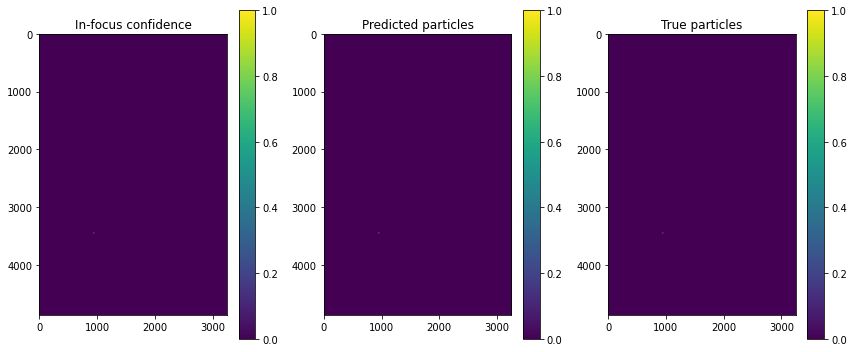

Plane: 86 at z: 0.026744 plane_f1: 0.5184 holo_f1: 0.5592 plane_csi: 0.3608 holo_csi: 0.4032:  10%|▉         | 99/1000 [22:50<3:54:35, 15.62s/it]            

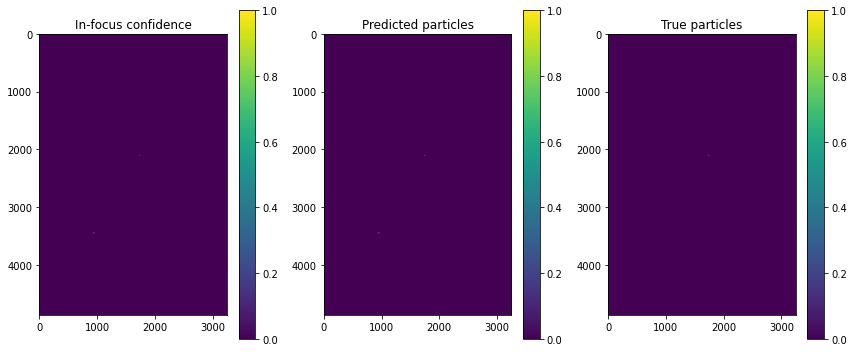

Plane: 87 at z: 0.026888 plane_f1: nan holo_f1: 0.5562 plane_csi: 0.0000 holo_csi: 0.4002:  10%|█         | 100/1000 [23:06<3:54:26, 15.63s/it]  

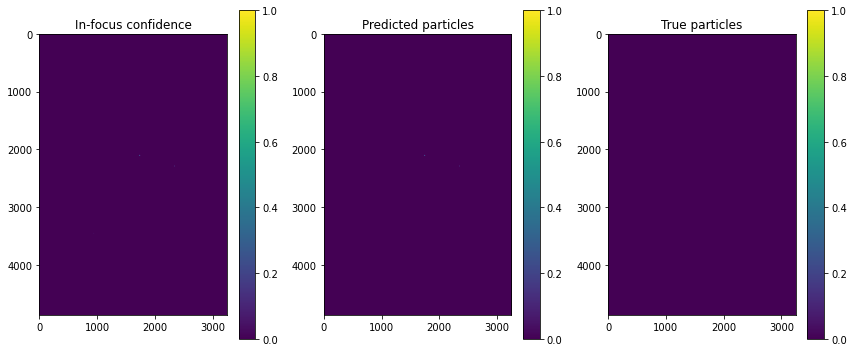

Plane: 88 at z: 0.027031 plane_f1: 0.9014 holo_f1: 0.5571 plane_csi: 0.8710 holo_csi: 0.4011:  10%|█         | 101/1000 [23:22<3:54:40, 15.66s/it]

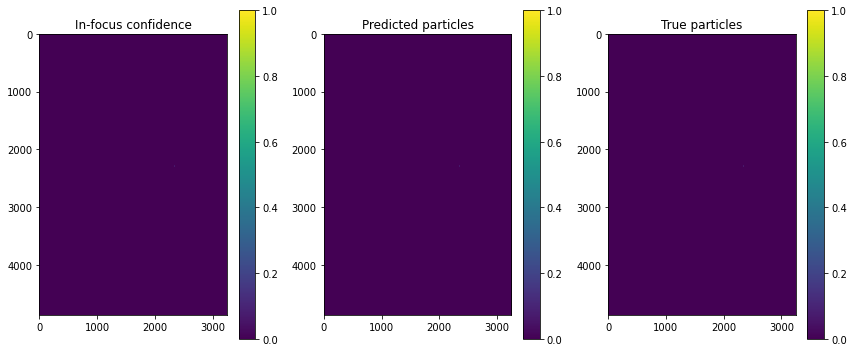

Plane: 89 at z: 0.027174999999999998 plane_f1: nan holo_f1: 0.5571 plane_csi: 0.0000 holo_csi: 0.4011:  10%|█         | 102/1000 [23:37<3:54:30, 15.67s/it]

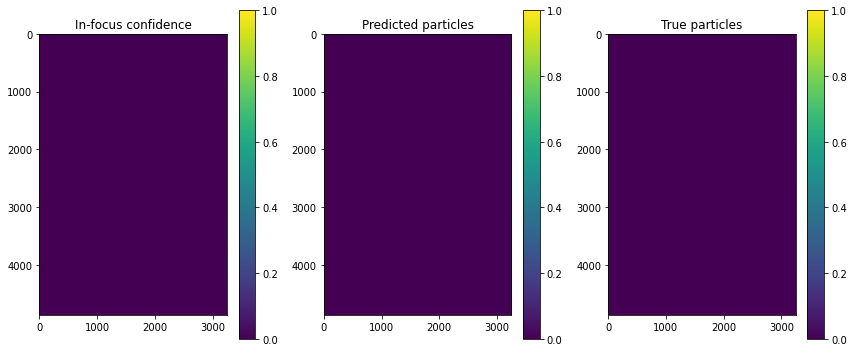

Plane: 90 at z: 0.027319999999999997 plane_f1: nan holo_f1: 0.5571 plane_csi: 0.0000 holo_csi: 0.4011:  10%|█         | 103/1000 [23:53<3:55:05, 15.72s/it]

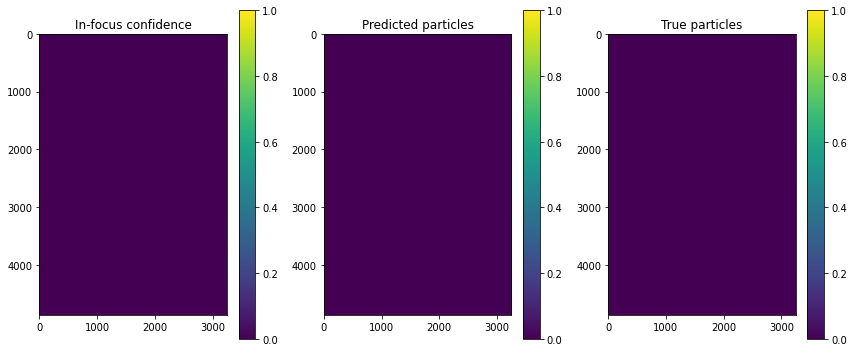

Plane: 91 at z: 0.027464 plane_f1: 0.9792 holo_f1: 0.5589 plane_csi: 1.0000 holo_csi: 0.4030:  10%|█         | 105/1000 [24:09<3:03:16, 12.29s/it]         

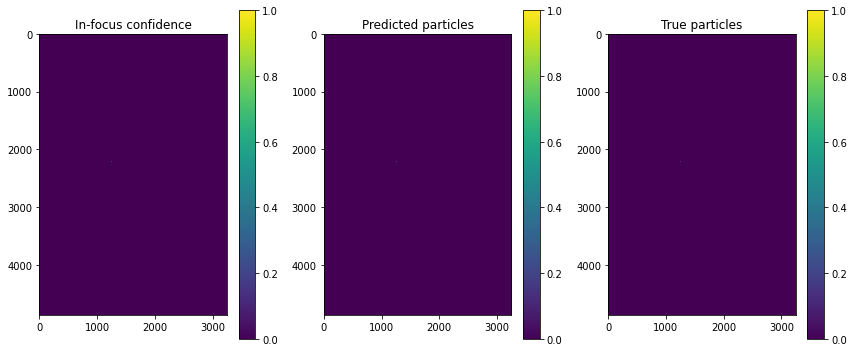

Plane: 92 at z: 0.027607 plane_f1: nan holo_f1: 0.5589 plane_csi: 0.0000 holo_csi: 0.4030:  11%|█         | 106/1000 [24:25<3:19:03, 13.36s/it]   

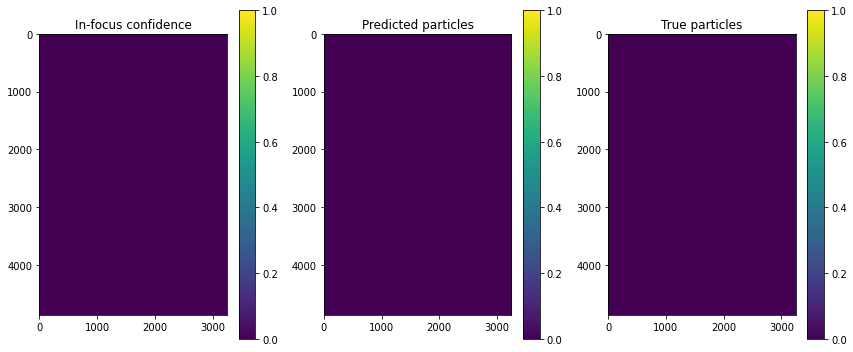

Plane: 93 at z: 0.027750999999999998 plane_f1: nan holo_f1: 0.5589 plane_csi: 0.0000 holo_csi: 0.4030:  11%|█         | 107/1000 [24:41<3:28:58, 14.04s/it]

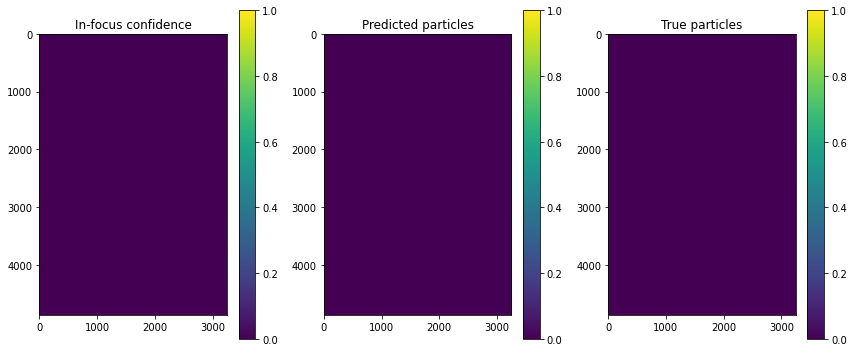

Plane: 94 at z: 0.027895999999999997 plane_f1: nan holo_f1: 0.5589 plane_csi: 0.0000 holo_csi: 0.4030:  11%|█         | 108/1000 [24:56<3:35:48, 14.52s/it]

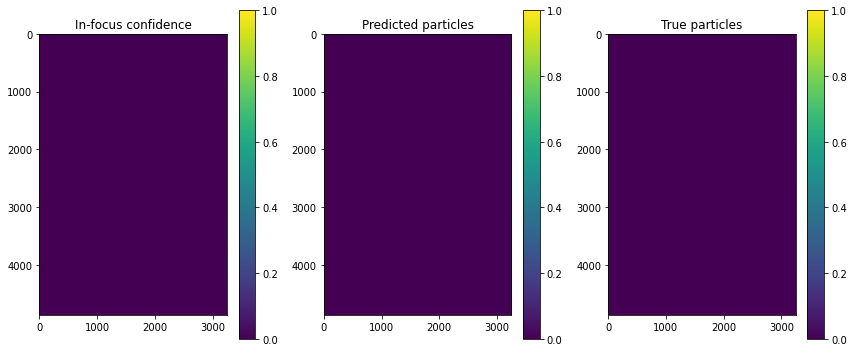

Plane: 95 at z: 0.02804 plane_f1: nan holo_f1: 0.5588 plane_csi: 0.0000 holo_csi: 0.4030:  11%|█         | 109/1000 [25:12<3:41:04, 14.89s/it]             

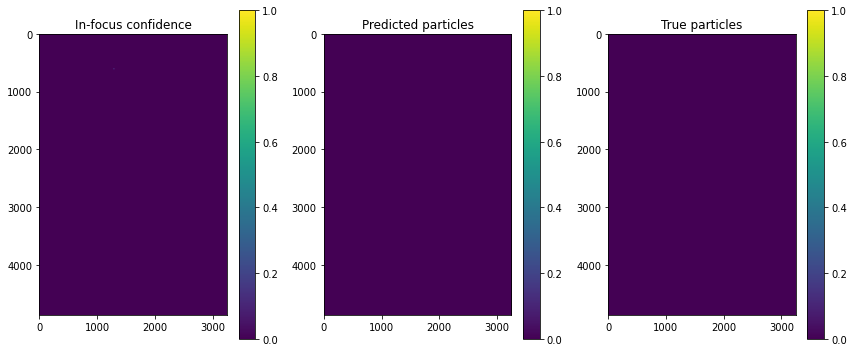

Plane: 96 at z: 0.028183 plane_f1: nan holo_f1: 0.5536 plane_csi: 0.0000 holo_csi: 0.3978:  11%|█         | 110/1000 [25:28<3:45:28, 15.20s/it]

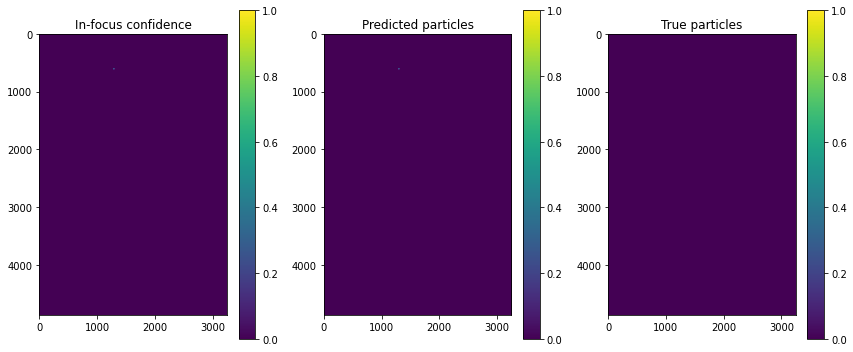

Plane: 97 at z: 0.028326999999999998 plane_f1: 0.9694 holo_f1: 0.5612 plane_csi: 0.9805 holo_csi: 0.4054:  11%|█         | 111/1000 [25:44<3:47:45, 15.37s/it]

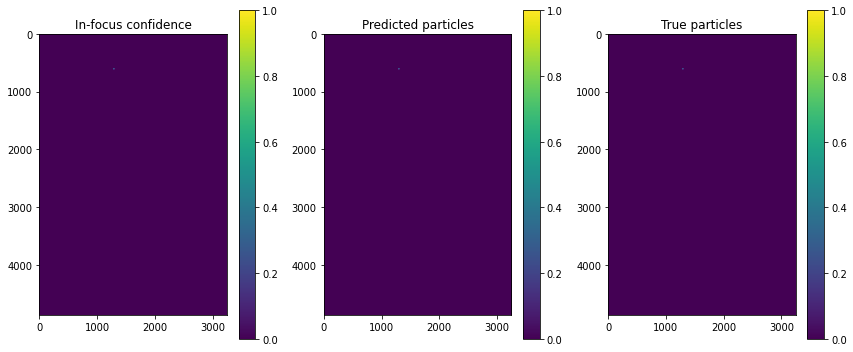

Plane: 98 at z: 0.028471999999999997 plane_f1: nan holo_f1: 0.5611 plane_csi: 0.0000 holo_csi: 0.4054:  11%|█         | 112/1000 [26:00<3:50:21, 15.56s/it]   

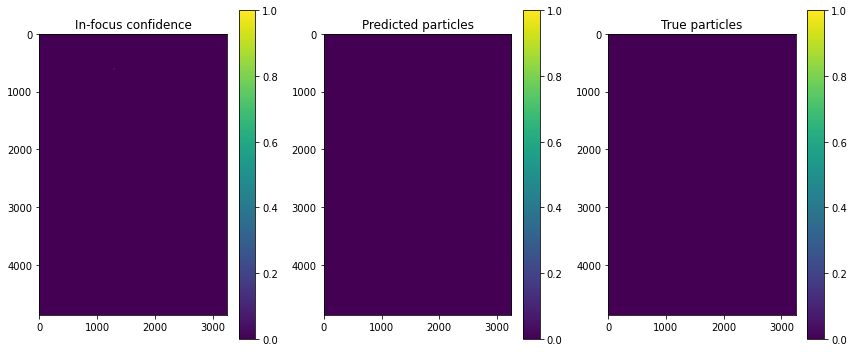

Plane: 99 at z: 0.028616 plane_f1: nan holo_f1: 0.5611 plane_csi: 0.0000 holo_csi: 0.4054:  11%|█▏        | 113/1000 [26:15<3:50:34, 15.60s/it]            

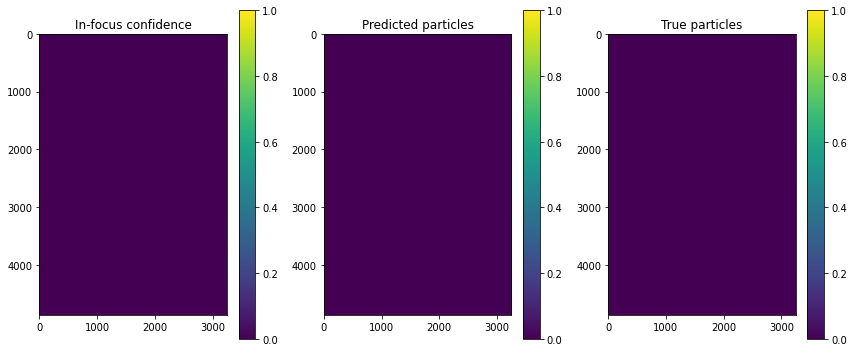

Plane: 100 at z: 0.028759999999999997 plane_f1: nan holo_f1: 0.5611 plane_csi: 0.0000 holo_csi: 0.4054:  11%|█▏        | 114/1000 [26:31<3:50:18, 15.60s/it]

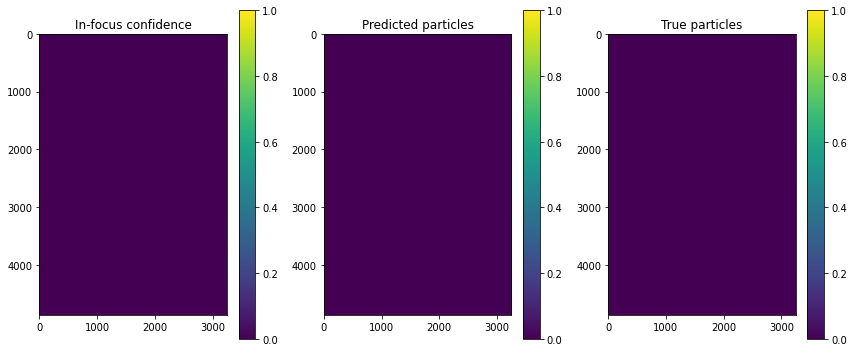

Plane: 101 at z: 0.028904 plane_f1: nan holo_f1: 0.5611 plane_csi: 0.0000 holo_csi: 0.4054:  12%|█▏        | 115/1000 [26:47<3:50:04, 15.60s/it]            

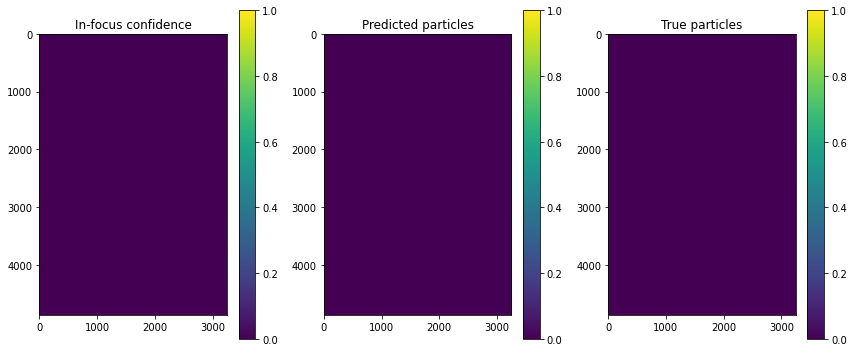

Plane: 102 at z: 0.029047999999999997 plane_f1: 0.9580 holo_f1: 0.5651 plane_csi: 0.9652 holo_csi: 0.4094:  12%|█▏        | 116/1000 [27:02<3:50:55, 15.67s/it]

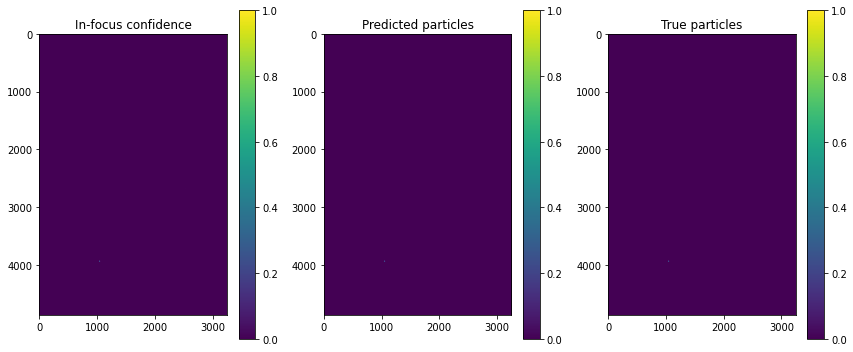

Plane: 103 at z: 0.029192 plane_f1: nan holo_f1: 0.5618 plane_csi: 0.0000 holo_csi: 0.4061:  12%|█▏        | 117/1000 [27:18<3:50:49, 15.68s/it]               

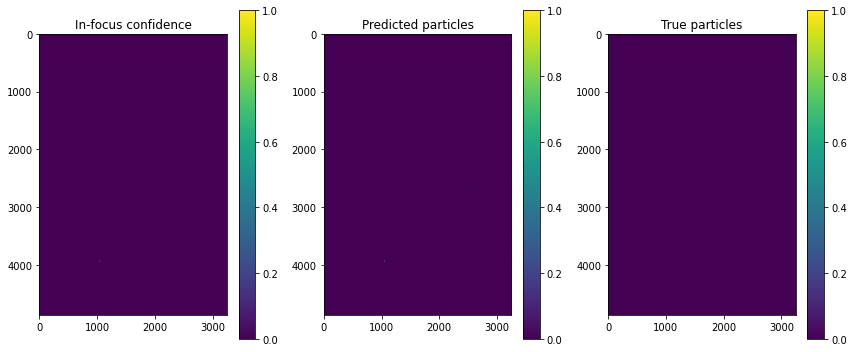

Plane: 103 at z: 0.029192 plane_f1: nan holo_f1: 0.5618 plane_csi: 0.0000 holo_csi: 0.4061:  10%|█         | 104/1000 [27:21<3:55:42, 15.78s/it]


KeyboardInterrupt: 

In [19]:
plot = True
save_arrays = False

model.eval()
with torch.no_grad():

    jiter = tqdm.tqdm(
        enumerate(inference_generator), 
        total = len(z_list),
        leave=True
    )

    roc = DistributedROC(thresholds=thresholds, obs_threshold=obs_threshold)
    
    for z_idx, results_dict in jiter:

        # Get stuff from the results dictionary
        pred_label = results_dict["pred_output"]
        pred_prob = results_dict["pred_proba"]
        true_label = results_dict["true_output"]
        z_plane = int(results_dict["z_plane"])

        if save_arrays:
            # Save the giant matrices as sparse arrays, as most elements are zero
            save_sparse_csr(f"{model_loc}/propagated/prob_{h_idx}_{z_plane}.npz", scipy.sparse.csr_matrix(pred_prob))
            save_sparse_csr(f"{model_loc}/propagated/pred_{h_idx}_{z_plane}.npz", scipy.sparse.csr_matrix(pred_label))
            save_sparse_csr(f"{model_loc}/propagated/true_{h_idx}_{z_plane}.npz", scipy.sparse.csr_matrix(true_label))

        # Merge the ROC result 
        this_roc = results_dict["roc"]
        roc.merge(this_roc)
        
        # Print some stuff
        plane = this_roc.binary_metrics()
        hologram = roc.binary_metrics()
        
        to_print = f"Plane: {z_idx} at z: {z_plane*1e-6}"
        to_print += f" plane_f1: {np.mean(plane['f1']):.4f}"
        to_print += f" holo_f1: {np.mean(hologram['f1']):.4f}"
        to_print += f" plane_csi: {this_roc.max_csi():.4f}"
        to_print += f" holo_csi: {roc.max_csi():.4f}"
        jiter.set_description(to_print)
        jiter.update()
        
        with open(f"{model_loc}/roc/roc_{h_idx}_{z_plane}.pkl", "wb") as fid:
            joblib.dump(results_dict["roc"], fid)

        # Option to plot each result per plane
        if plot:
            fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (12, 5))
            p1 = ax0.imshow(pred_prob, vmin = 0,  vmax = 1)
            ax0.set_title("In-focus confidence")
            fig.colorbar(p1, ax=ax0)

            p2 = ax1.imshow(pred_label, vmin = 0,  vmax = 1)
            ax1.set_title("Predicted particles")
            fig.colorbar(p2, ax=ax1)

            p3 = ax2.imshow(true_label, vmin = 0, vmax = 1)
            ax2.set_title("True particles")
            fig.colorbar(p3, ax=ax2)

            plt.tight_layout()
            plt.show()

In [ ]:
rocs = sorted(glob.glob(f"{model_loc}/roc/roc_{h_idx}_*.pkl"), 
                  key = lambda x: int(x.strip(".pkl").split("_")[-1]))
    
for k, roc_fn in enumerate(rocs):
    with open(roc_fn, "rb") as fid:
        if k == 0:
            roc = joblib.load(fid)
        else:
            roc.merge(joblib.load(fid))

with open(f"{model_loc}/roc/roc_{h_idx}.pkl", "wb") as fid:
    joblib.dump(roc, fid)

model_name = "U-Net-18"
roc_curve([roc], [model_name], ["orange"], ["o"], f"{model_loc}/images/roc_comparison_{h_idx}.png")
performance_diagram([roc], [model_name], ["orange"], ["o"], f"{model_loc}/images/performance_comparison_{h_idx}.png")